# 1. Fitting Ne lines in a loop
- This is the first step of fitting Diad data
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- You can install DiadFit through PyPI, simply uncomment this line. You only need to run this once per computer (until you want to get an upgraded version)
- Uncomment this line if you havent installed DiadFit, or are running a much older version. 

In [1]:
#!pip install --upgrade DiadFit

## Now import the packages you need
- When you communicate bugs with Penny, make sure you specify the version here.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
# This needs to be 0.0.68 or higher!
pf.__version__

'1.0.2'

##  Specifying paths
- Put your path here, e.g. where in your computer the spectra and metadata are saved

In [3]:
import os
DayFolder=os.getcwd()

if os.name=='posix':
    slash='/'
else:
    slash='\\'

meta_path=DayFolder +slash+ 'MetaData'
spectra_path=DayFolder +slash+ 'Spectra'

# Filetype and extension for spectra
spectra_filetype='headless_txt'
spectra_file_ext='.txt'
# file extension for spectra
meta_file_ext='.txt'
# Does your file start with a prefix? E.g 01 Ne_line.txt?
prefix=True
# If so - what is the character separating the prefix from the real name
prefix_str=' '
# Does your instrument have TruPower (WITEC)
TruPower=True
# Save settings to a file to use in all other notebooks
pf.save_settings(meta_path, spectra_path, spectra_filetype, prefix, prefix_str, spectra_file_ext, meta_file_ext, TruPower)


Good job! Filetype headless_txt is valid.


In [4]:
# This step gets all your Ne files. Enter ID_str as a string in only your Neon files, exclude strings not in Ne files. So here we take files with 'Ne' in the name and exclude those with 'diad' in the name. 
Ne_files=pf.get_files(path=spectra_path,
file_ext=spectra_file_ext, ID_str='Ne', 
exclude_str=['diad','Series'], sort=False)

Ne_files

['01 Ne--Spectrum--000--Spec.Data 1.txt',
 '02 Ne--Spectrum--001--Spec.Data 1.txt',
 '03 Ne--Spectrum--002--Spec.Data 1.txt',
 '04 Ne--Spectrum--003--Spec.Data 1.txt',
 '05 Ne--Spectrum--004--Spec.Data 1.txt',
 '06 Ne--Spectrum--005--Spec.Data 1.txt',
 '07 Ne--Spectrum--006--Spec.Data 1.txt',
 '08 Ne--Spectrum--007--Spec.Data 1.txt',
 '15 Ne--Spectrum--032--Spec.Data 1.txt',
 '17 Ne--Spectrum--036--Spec.Data 1.txt',
 '22 Ne--Spectrum--049--Spec.Data 1.txt',
 '27 Ne--Spectrum--062--Spec.Data 1.txt',
 '34 Ne--Spectrum--080--Spec.Data 1.txt',
 '36 Ne--Spectrum--085--Spec.Data 1.txt',
 '37 Ne--Spectrum--088--Spec.Data 1.txt',
 '39 Ne--Spectrum--090--Spec.Data 1.txt']

### Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [5]:
wavelength =532.046 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, 
cut_off_intensity=2000)
df_Ne.iloc[1:7]

Raman_shift (cm-1)  Intensity  Ne emission line in air
15          818.699523     5000.0                556.27662
23         1117.086987     5000.0                565.66588
30         1310.480205     5000.0                571.92248
33         1398.915133     5000.0                574.82985
37         1447.564622     7000.0                576.44188
40         1567.204978     5000.0                580.44496

### Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for each selected line

In [6]:
line_1=1117
line_2=1447
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
line1_shift=line_1, line2_shift=line_2,
cut_off_intensity=2000)
ideal_split

Ne_Split       Line_1       Line_2  Line_1_int  Line_2_int  \
0  330.477634  1117.086987  1447.564622      5000.0      7000.0   

   Entered Pos Line 1  Entered Pos Line 2  
0                1117                1447

## Select one file to tweak the fit for
- You can either do this numerically, or by specifiying the filename between ''

In [7]:
i=0 # Select one file
filename=Ne_files[i] 
print(filename)

01 Ne--Spectrum--000--Spec.Data 1.txt


## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook
- This also prints the heights of the other peaks so you could choose other Neons if you wanted to

Peak1_cent  Peak1_height   Peak2_cent  Peak2_height   Peak1_prom  \
0  1116.16583   5381.666504  1447.138537   40479.33203  4657.399854   

    Peak2_prom  
0  39755.06538

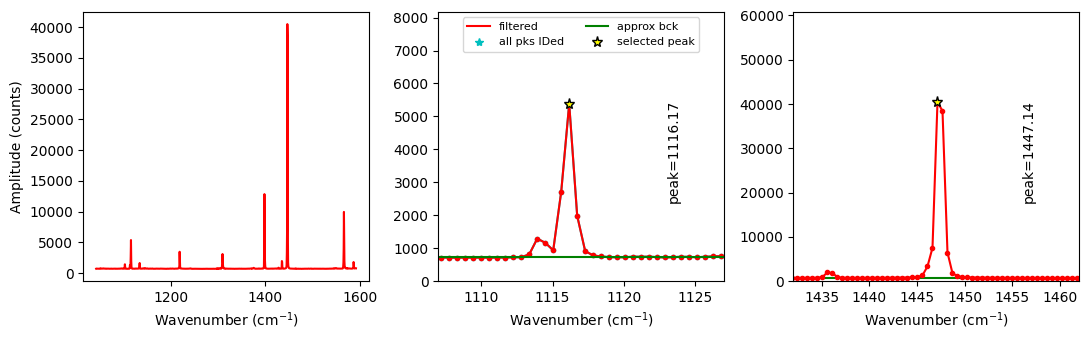

In [8]:
exclude_range_1=None
exclude_range_2=None

Neon_id_config=pf.Neon_id_config(height=10,  distance=1, prominence=10, 
            width=1, threshold=0.6,
            peak1_cent=line_1, peak2_cent=line_2, n_peaks=6, 
            exclude_range_1=exclude_range_1, 
            exclude_range_2=exclude_range_2)
Neon_id_config

Ne, df_fit_params=pf.identify_Ne_lines(path=spectra_path,
filename=filename, filetype=spectra_filetype,
config=Neon_id_config, print_df=False)
df_fit_params

### Tweak peak parameters
- One important thing is the background positions, these are defined relative to the peak position. Once you tweak them for each instrument, you chould be good to go. 
- Another thing is how many peaks you want for Peak1, 'peaks_1', for the 1117 line, you'll need 2 if you have the clear secondary peak seen above. 

In [9]:
pf.Ne_peak_config()

Ne_peak_config(model_name='PseudoVoigtModel', N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), peaks_1=2, peaks_2=1, DeltaNe_ideal=330.477634, x_range_baseline_pk1=20, y_range_baseline_pk1=200, x_range_baseline_pk2=20, y_range_baseline_pk2=200, pk1_sigma=0.4, pk2_sigma=0.4, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), LH_offset_mini2=None, x_span_pk1=None, x_span_pk2=None)

In [10]:
model_name='PseudoVoigtModel'
Ne_Config_est=pf.pf.Ne_peak_config(model_name=model_name,
 DeltaNe_ideal=ideal_split['Ne_Split'], peaks_1=2, LH_offset_mini=[0.5, 3],
pk1_sigma=0.6, pk2_sigma=0.3,
lower_bck_pk1=(-40, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
lower_bck_pk2=[-40, -30], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
x_range_peak=5, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10],
N_poly_pk2_baseline=2 )

filename  1σ_Ne_Corr_test  1σ_Ne_Corr  \
0  Ne--Spectrum--000--Spec.Data 1.txt         0.000037    0.000037   

   pk2_peak_cent  pk2_amplitude  pk2_sigma pk2_gamma  error_pk2  \
0    1447.387696   52484.899726   0.410488      None   0.001474   

   Peak2_Prop_Lor  pk1_peak_cent  ...  Peak1_Prop_Lor     deltaNe   Ne_Corr  \
0        0.398262    1116.102023  ...        0.299275  331.285673  0.997561   

   Ne_Corr_min  Ne_Corr_max  residual_pk2  residual_pk1  residual_pk1+pk2  \
0      0.99752     0.997602     126.01841     12.908082        138.926492   

   error_pk1_amplitude  error_pk2_amplitude  
0           202.372668           432.341846  

[1 rows x 24 columns]

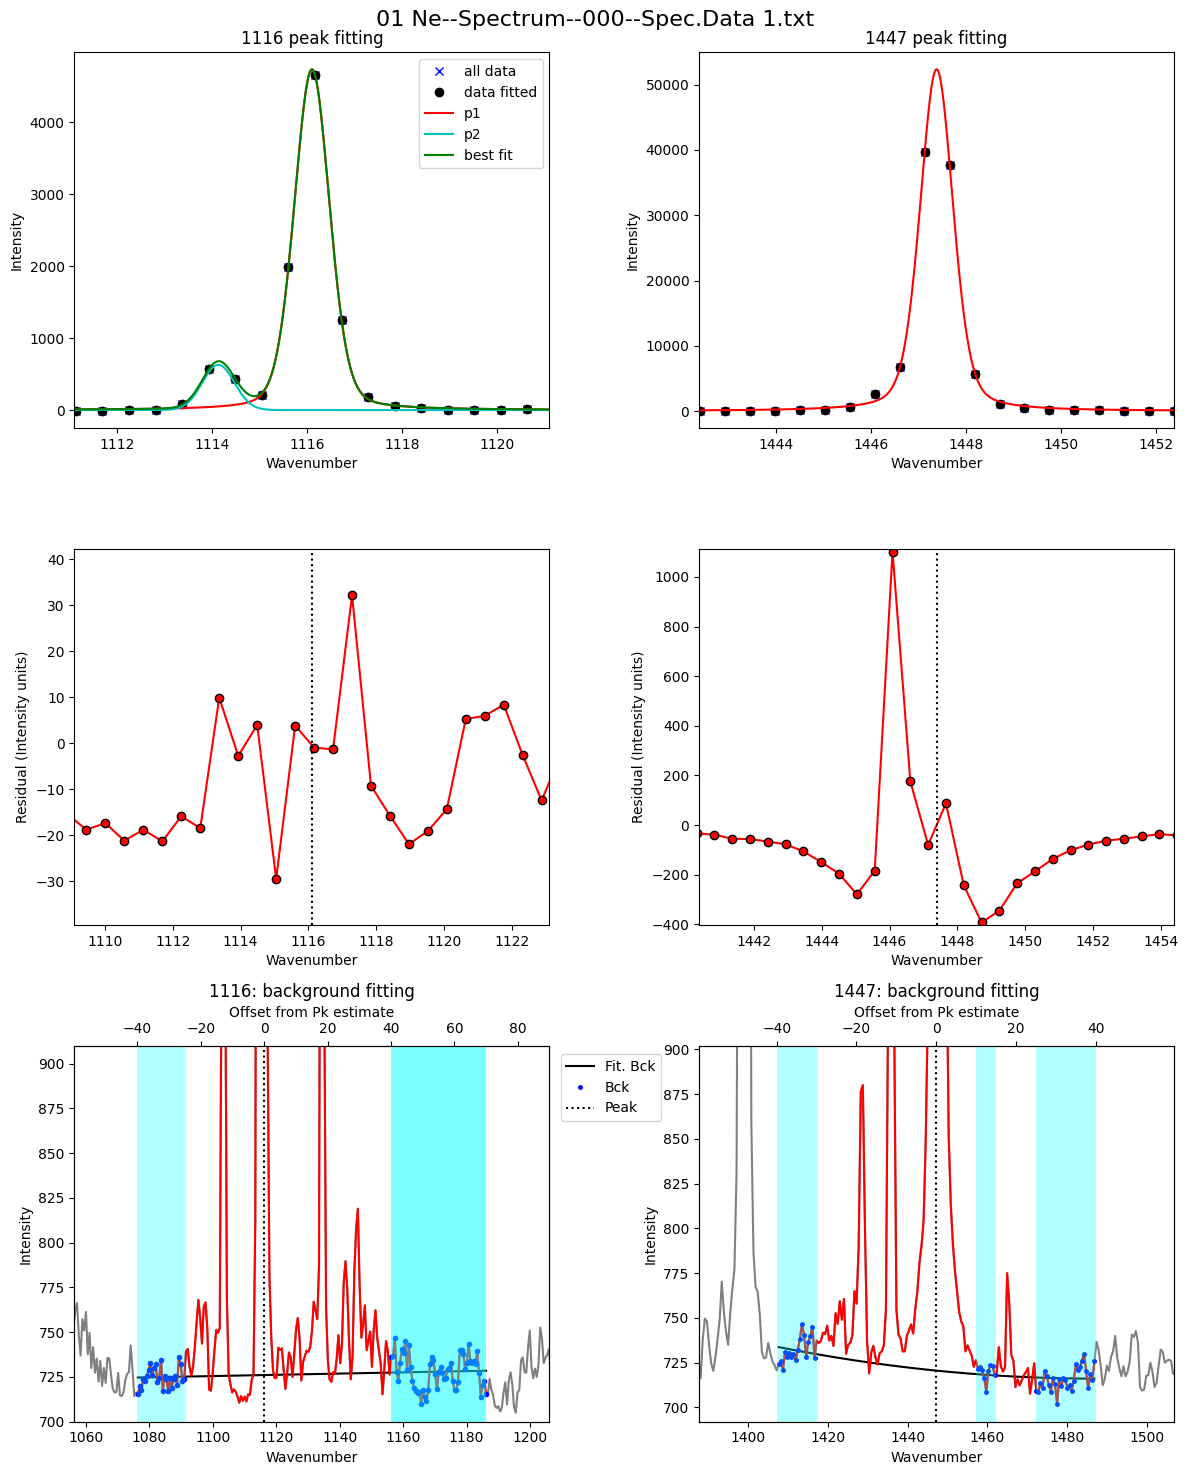

In [11]:

df_test_params=pf.fit_Ne_lines(Ne=Ne, filename=filename,
path=spectra_path, prefix=prefix,
config=Ne_Config_est,
    Ne_center_1=df_fit_params['Peak1_cent'].iloc[0], 
    Ne_center_2=df_fit_params['Peak2_cent'].iloc[0],
    Ne_prom_1=df_fit_params['Peak1_prom'].iloc[0],
    Ne_prom_2=df_fit_params['Peak2_prom'].iloc[0],
    const_params=False)                                                                 
                                                                     
display(df_test_params)

In [12]:
## Now tweak the values of the sigma to help with the looping - then for looping we let these parameters only vary +-20% between spectra
Ne_Config_est.pk1_sigma=df_test_params['pk1_sigma'][0]
Ne_Config_est.pk2_sigma=df_test_params['pk2_sigma'][0]


## Now fit all Ne files here using these parameters. 
- If you select plot_figure=False, the loop will be quick. 
- But if its True, you can to inspect the figures.

  0%|          | 0/16 [00:00<?, ?it/s]

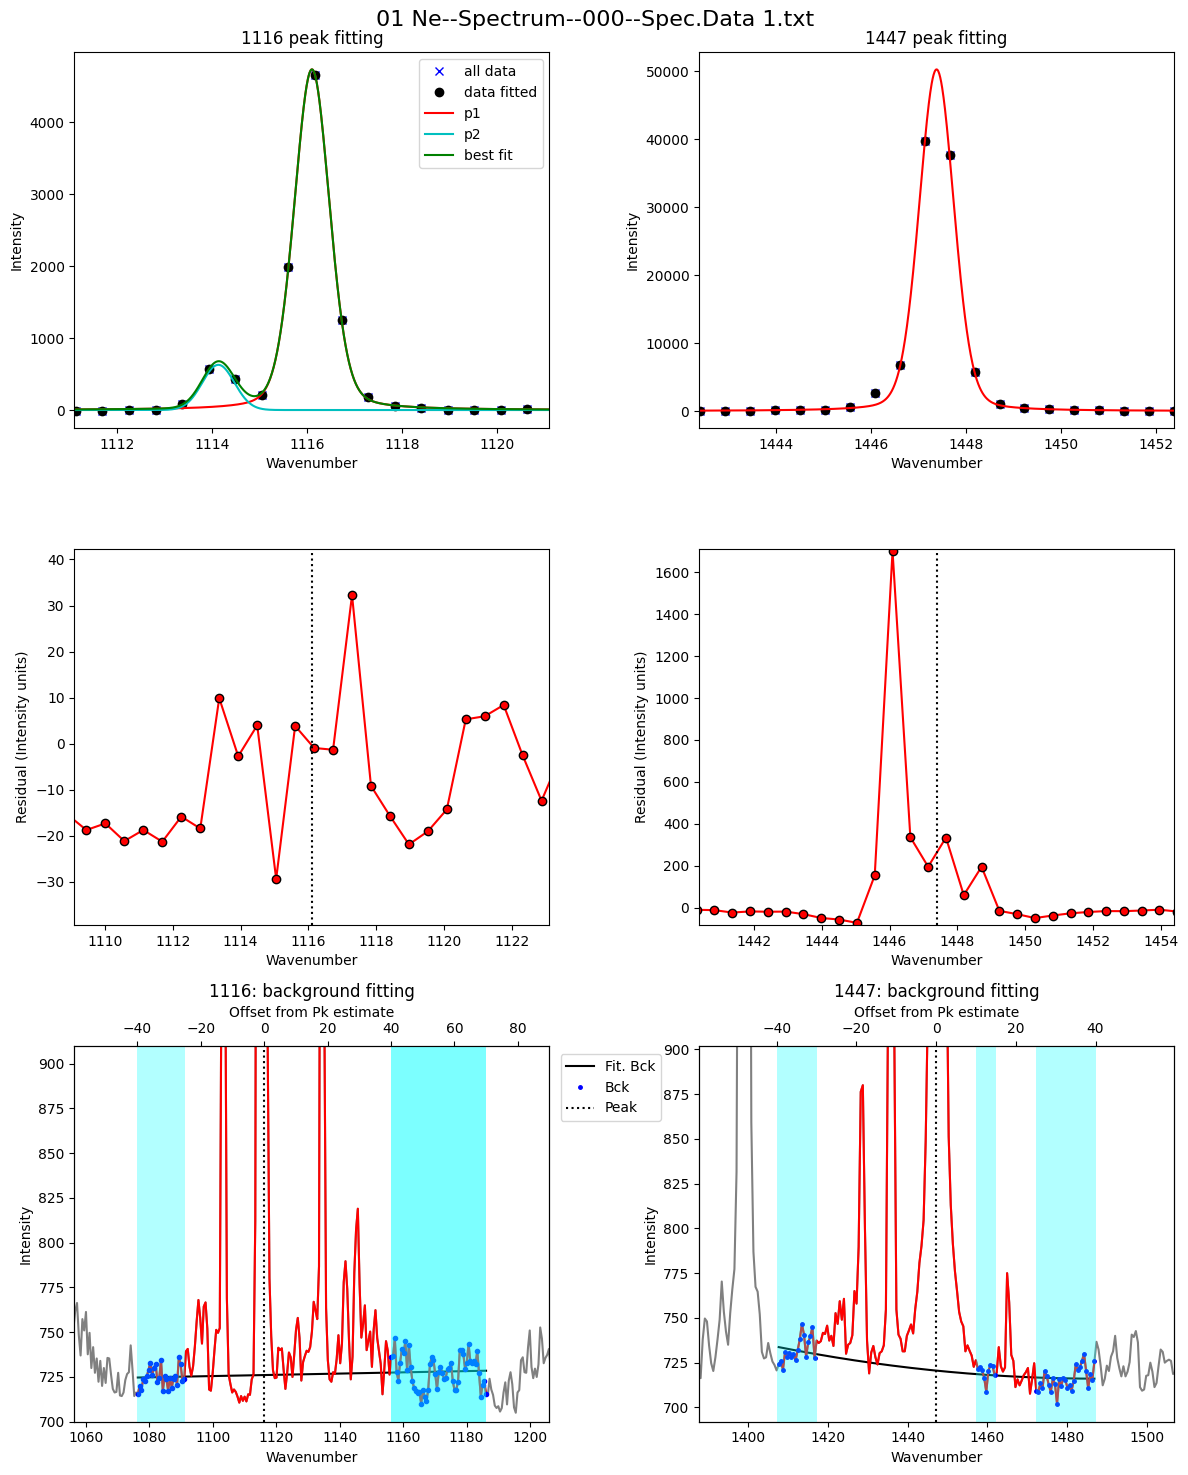

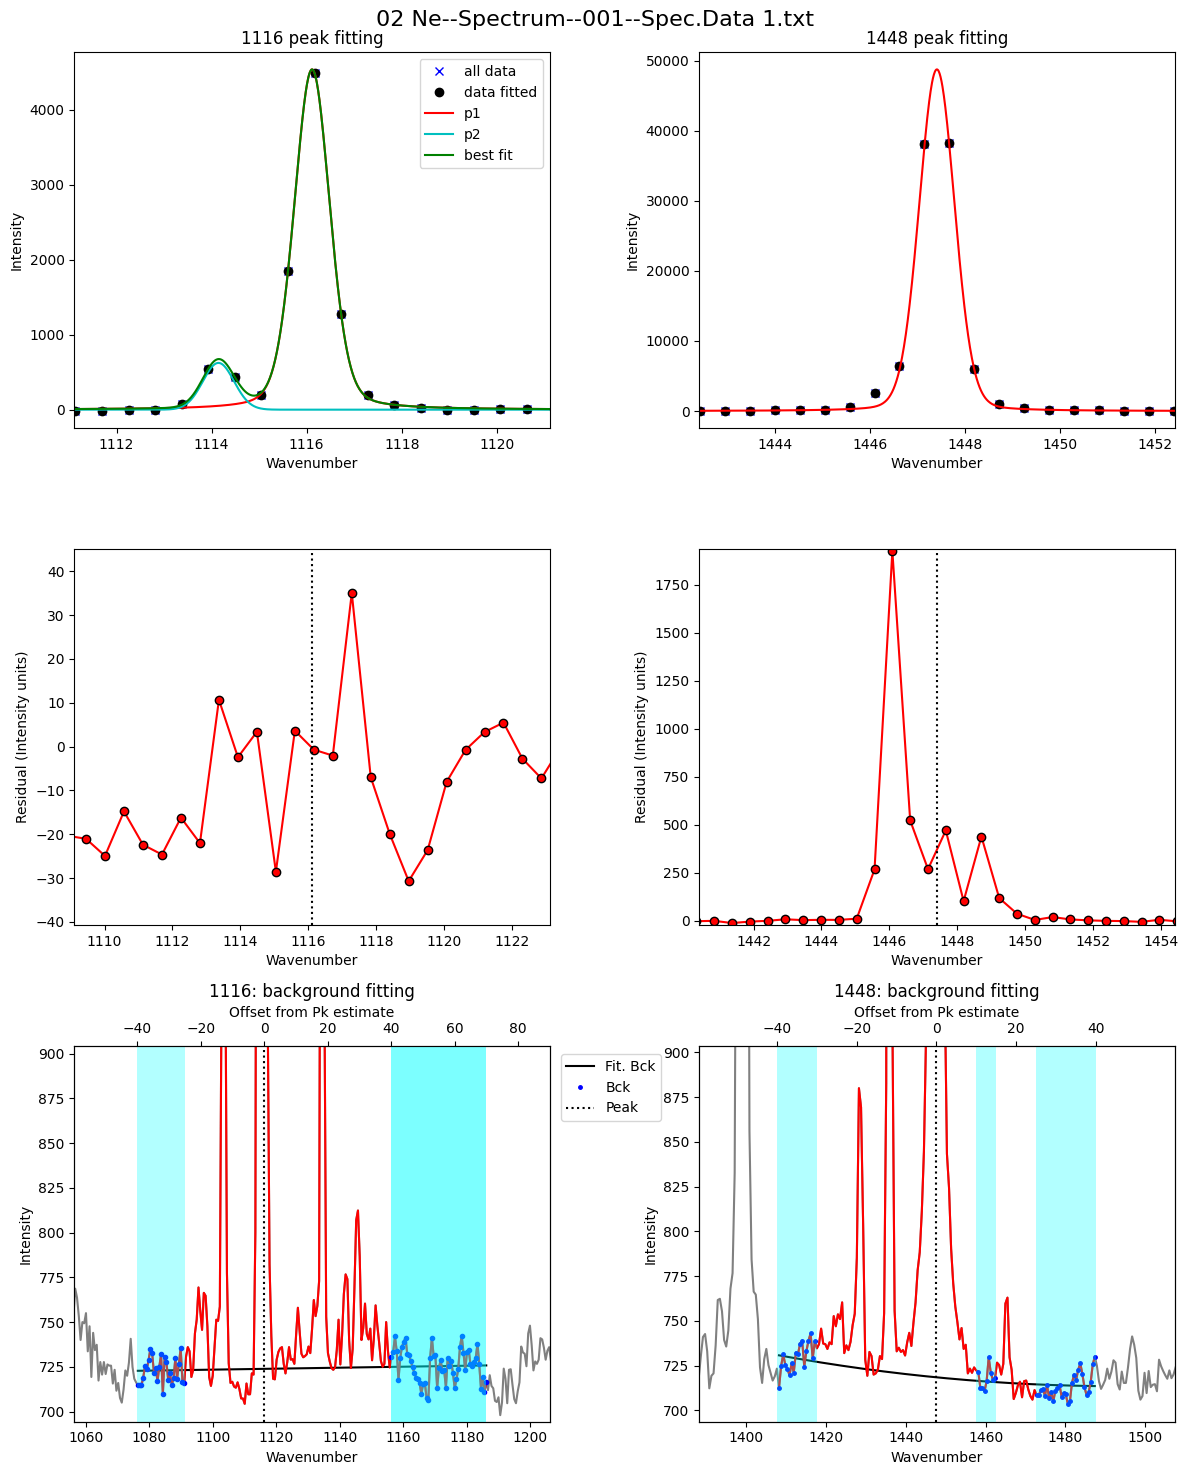

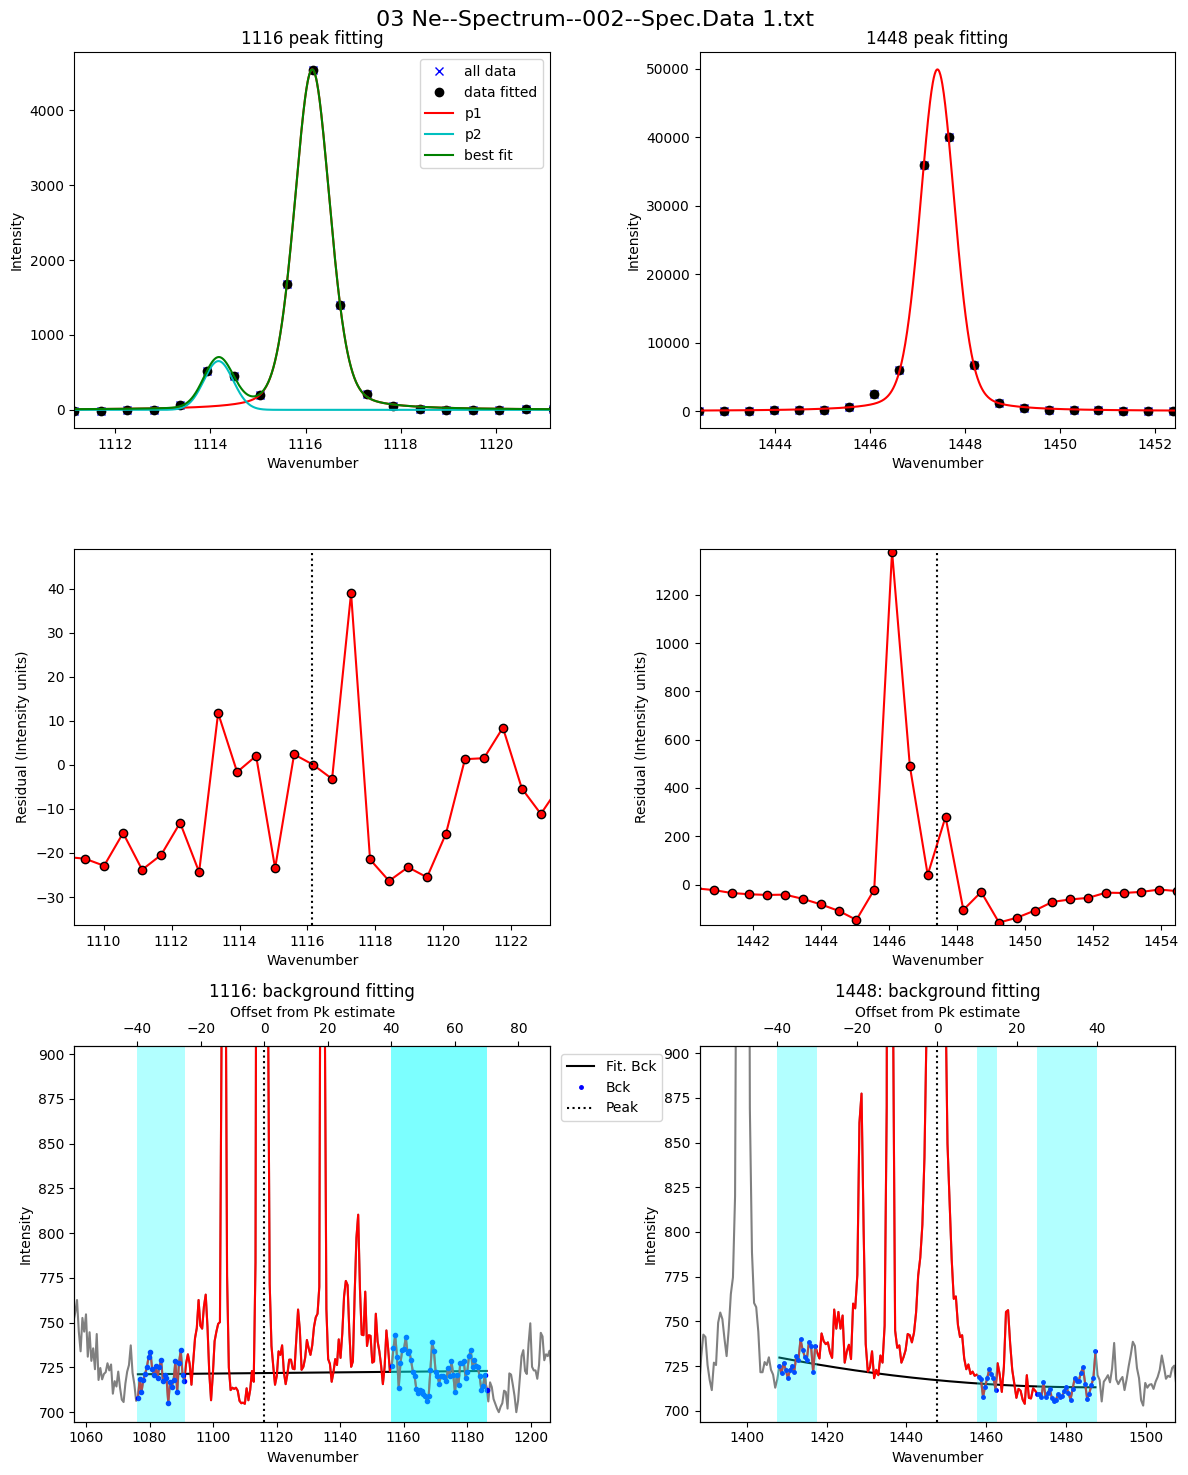

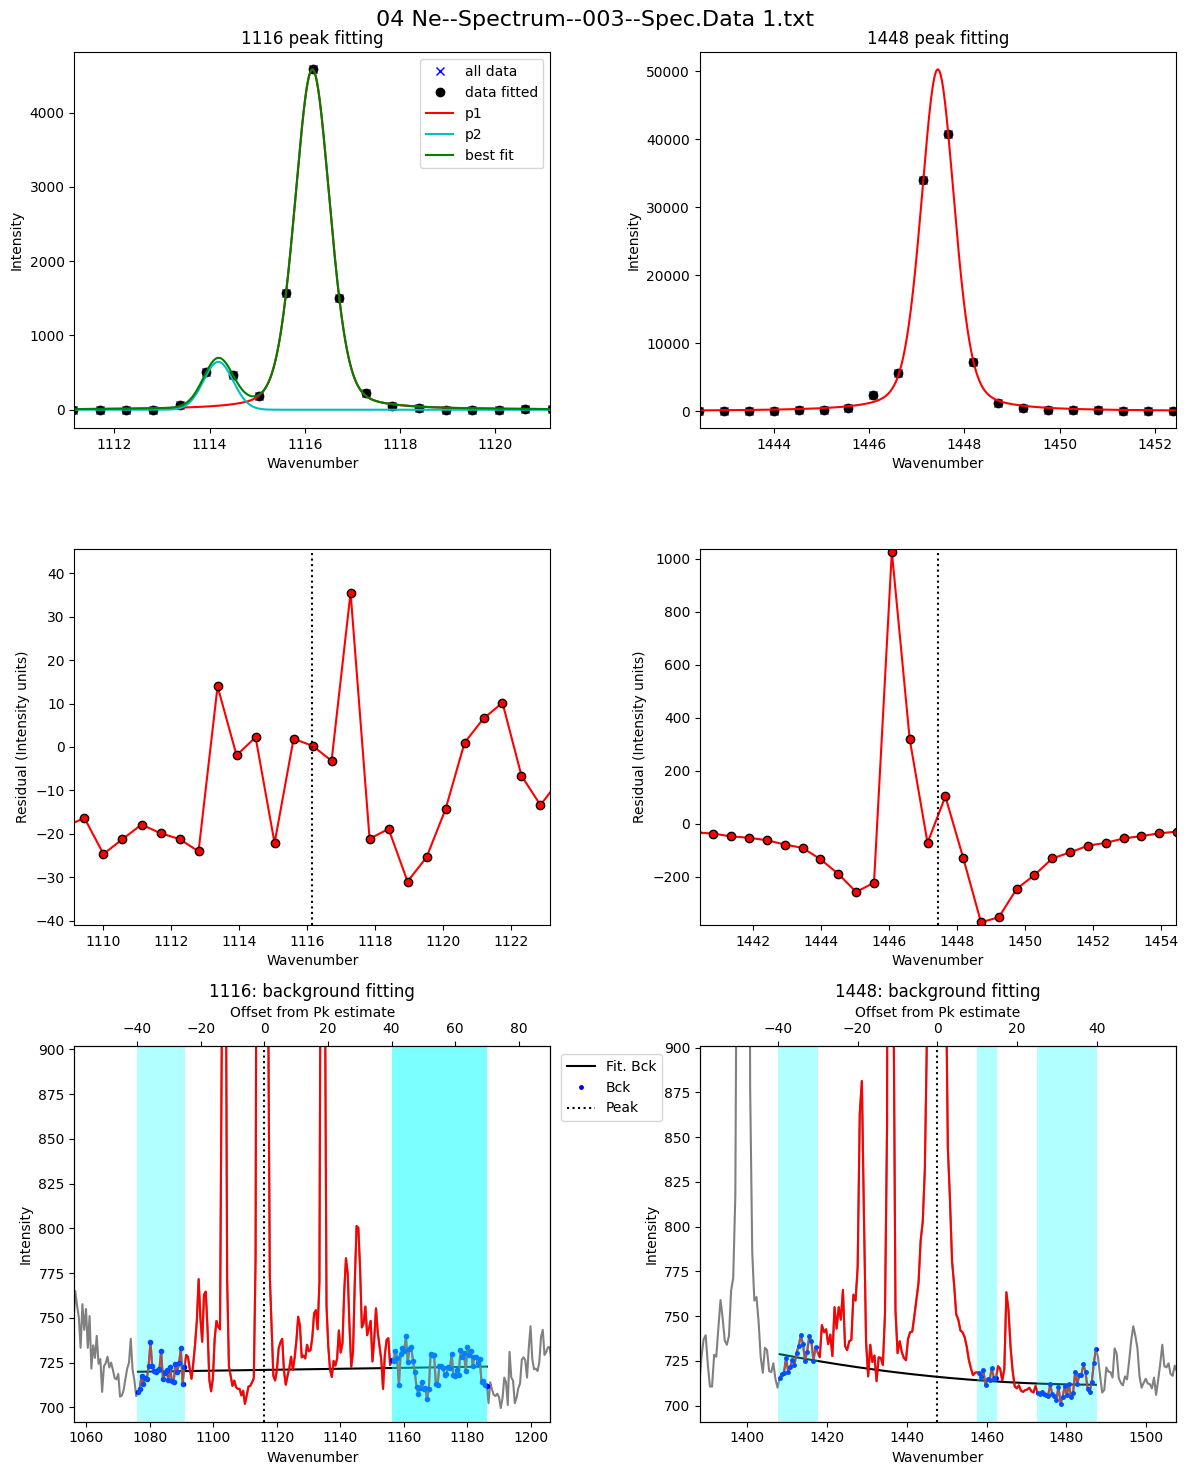

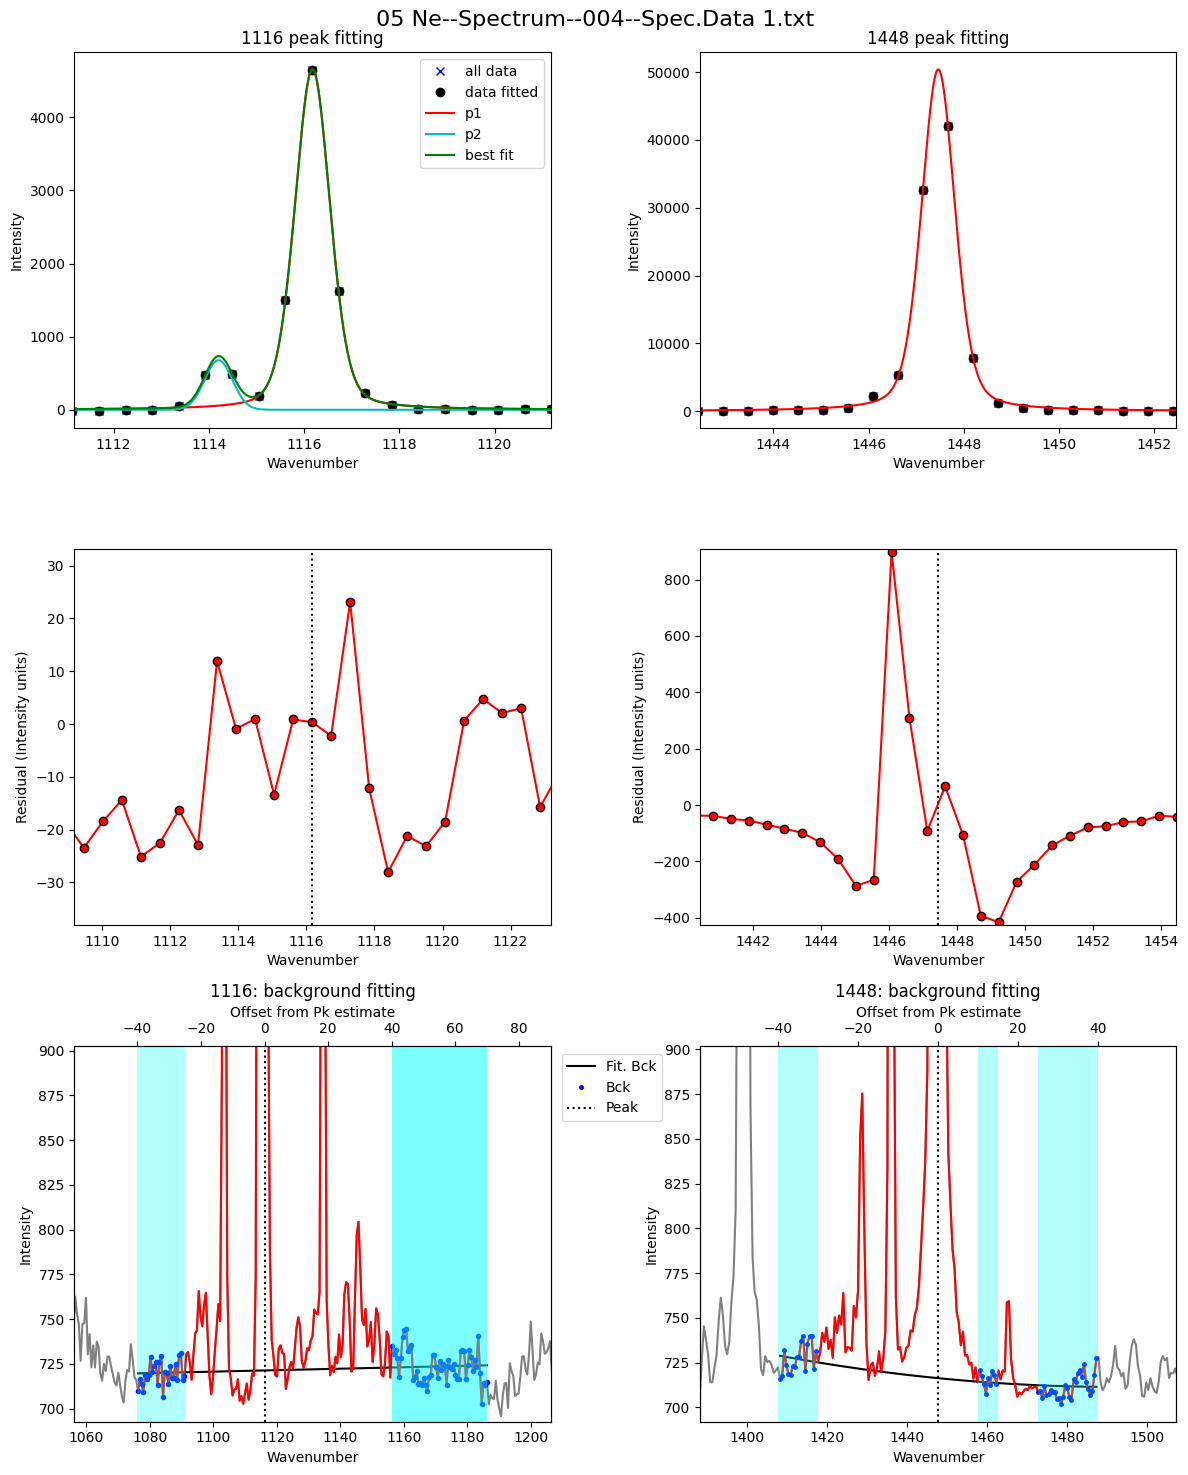

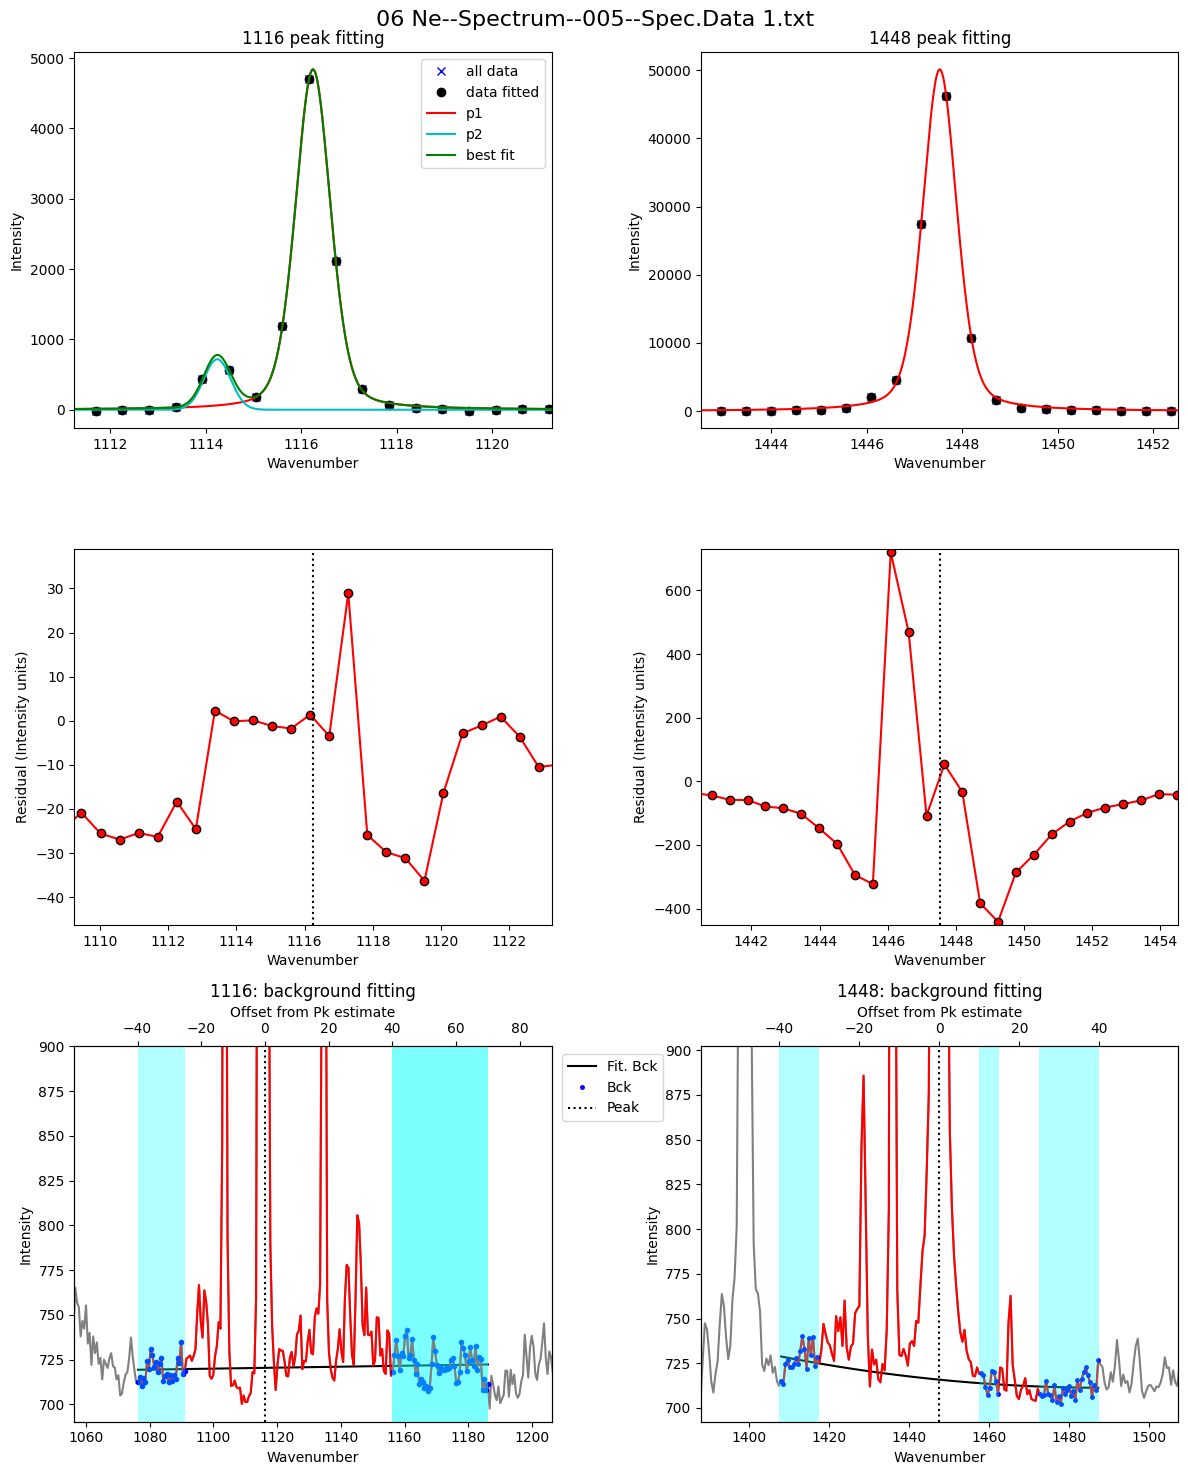

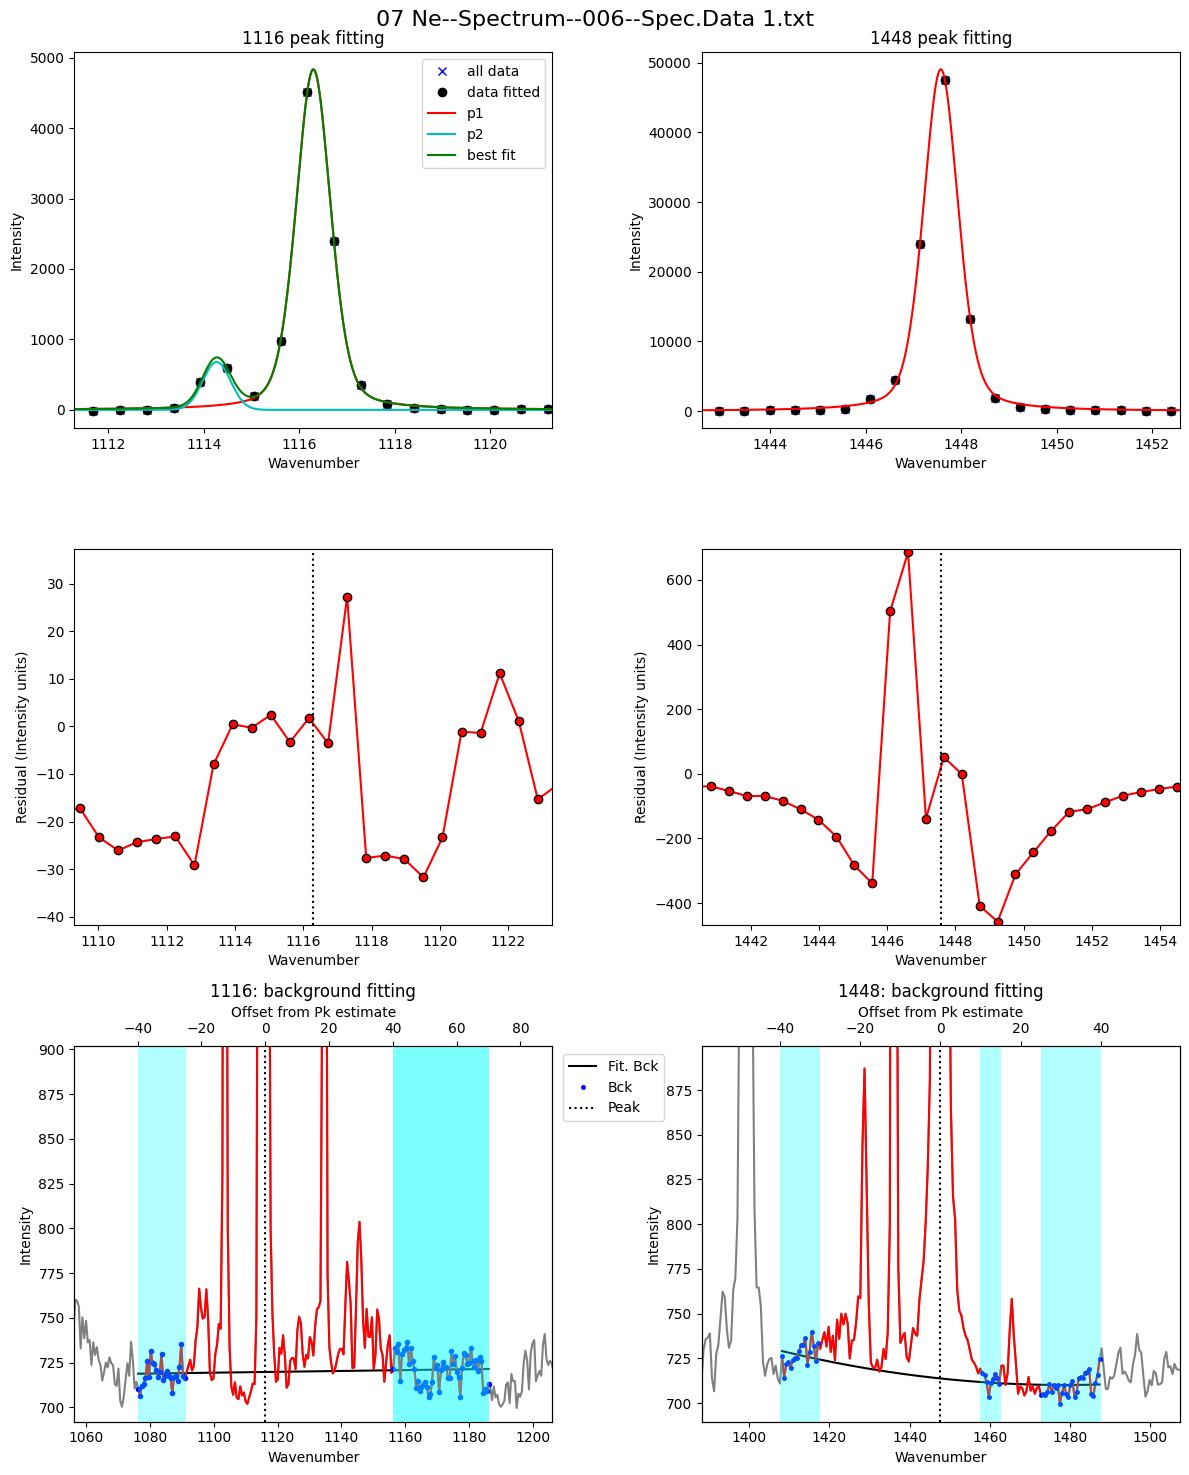

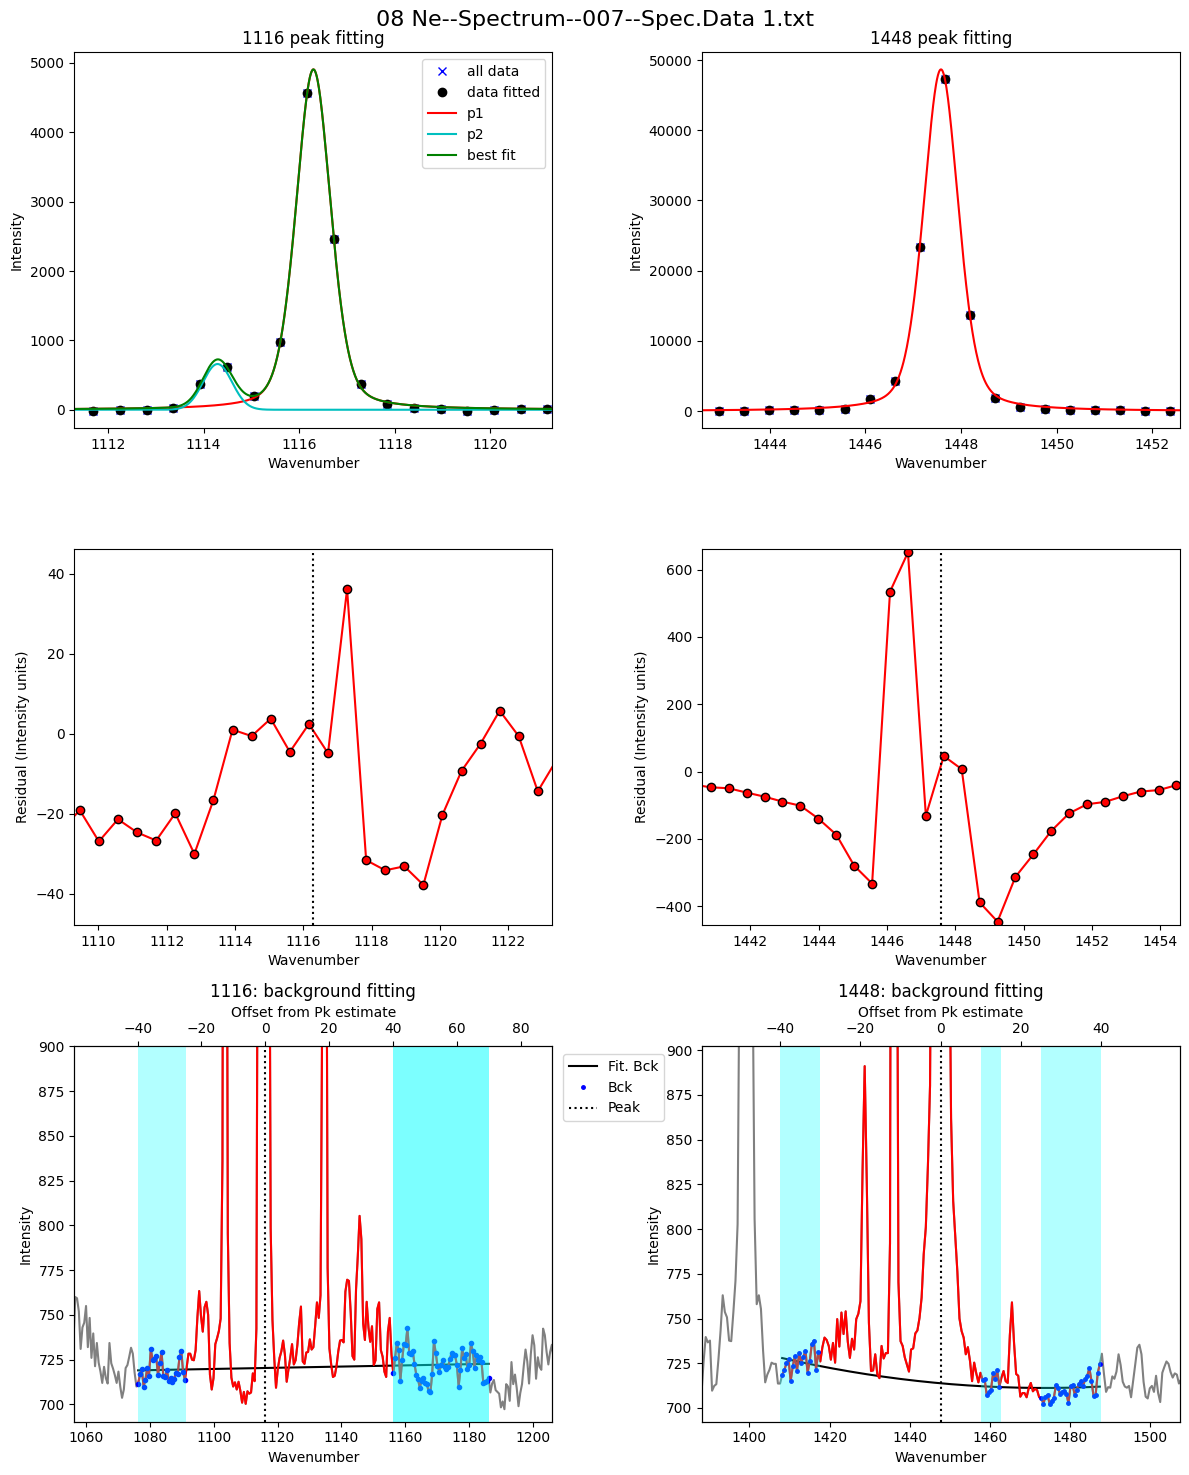

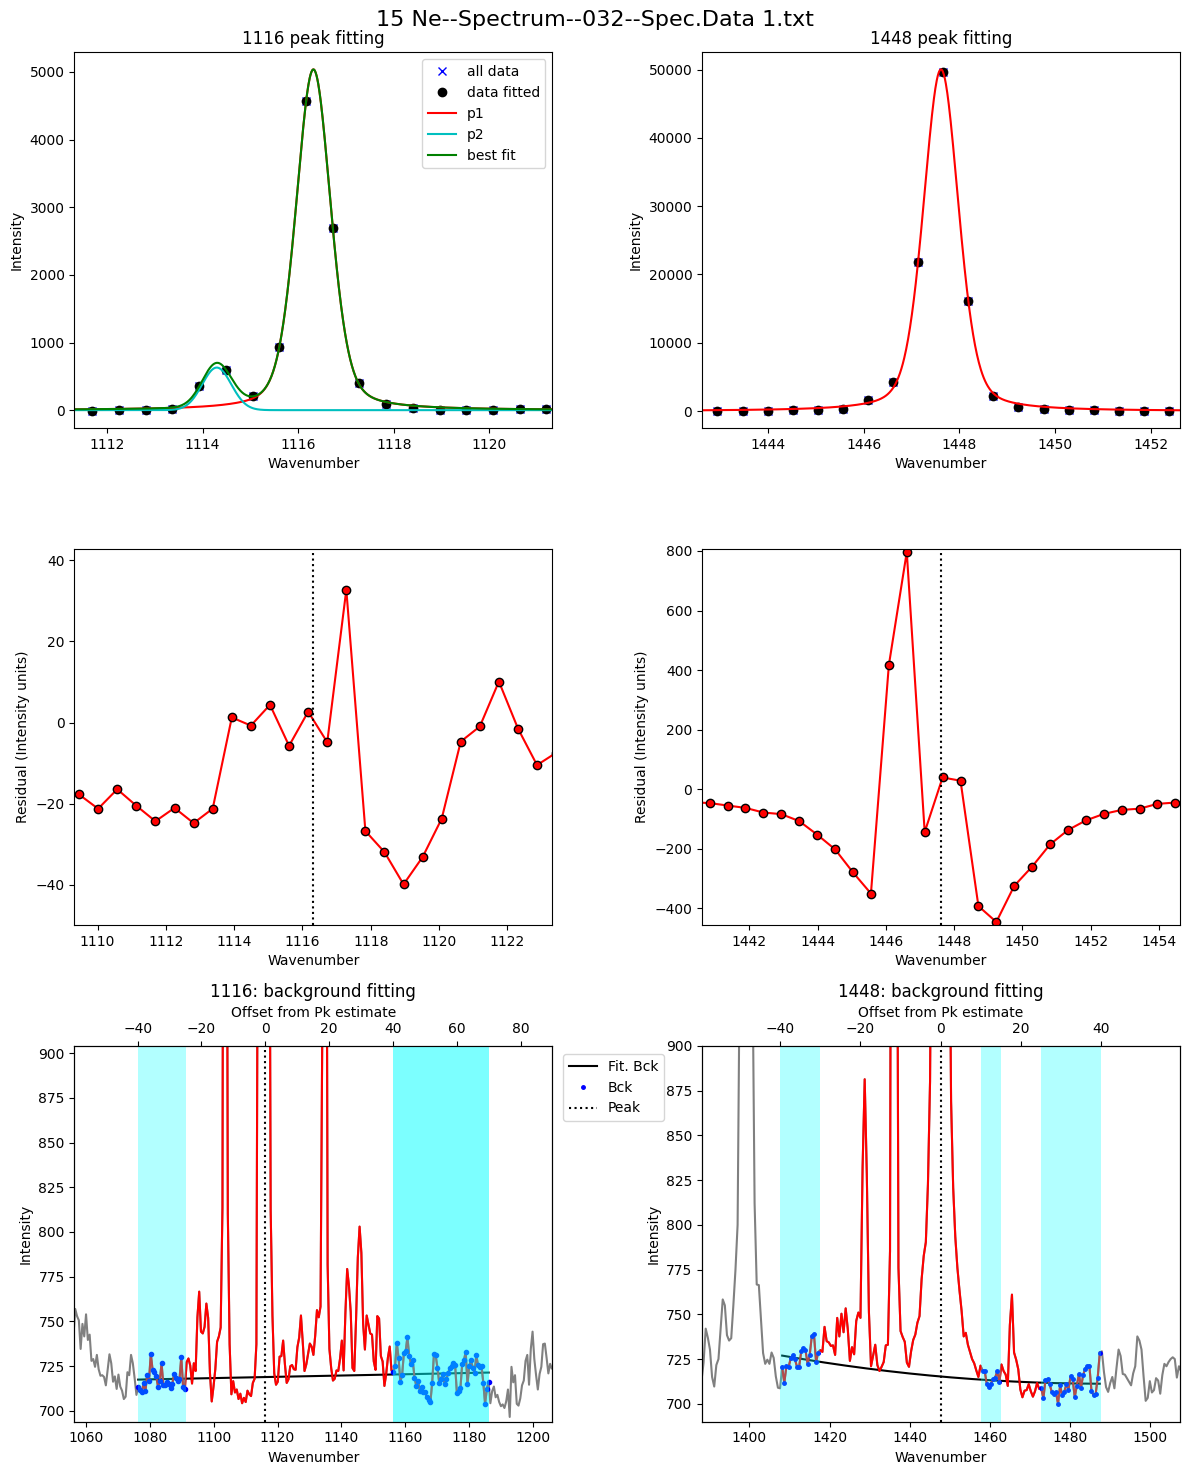

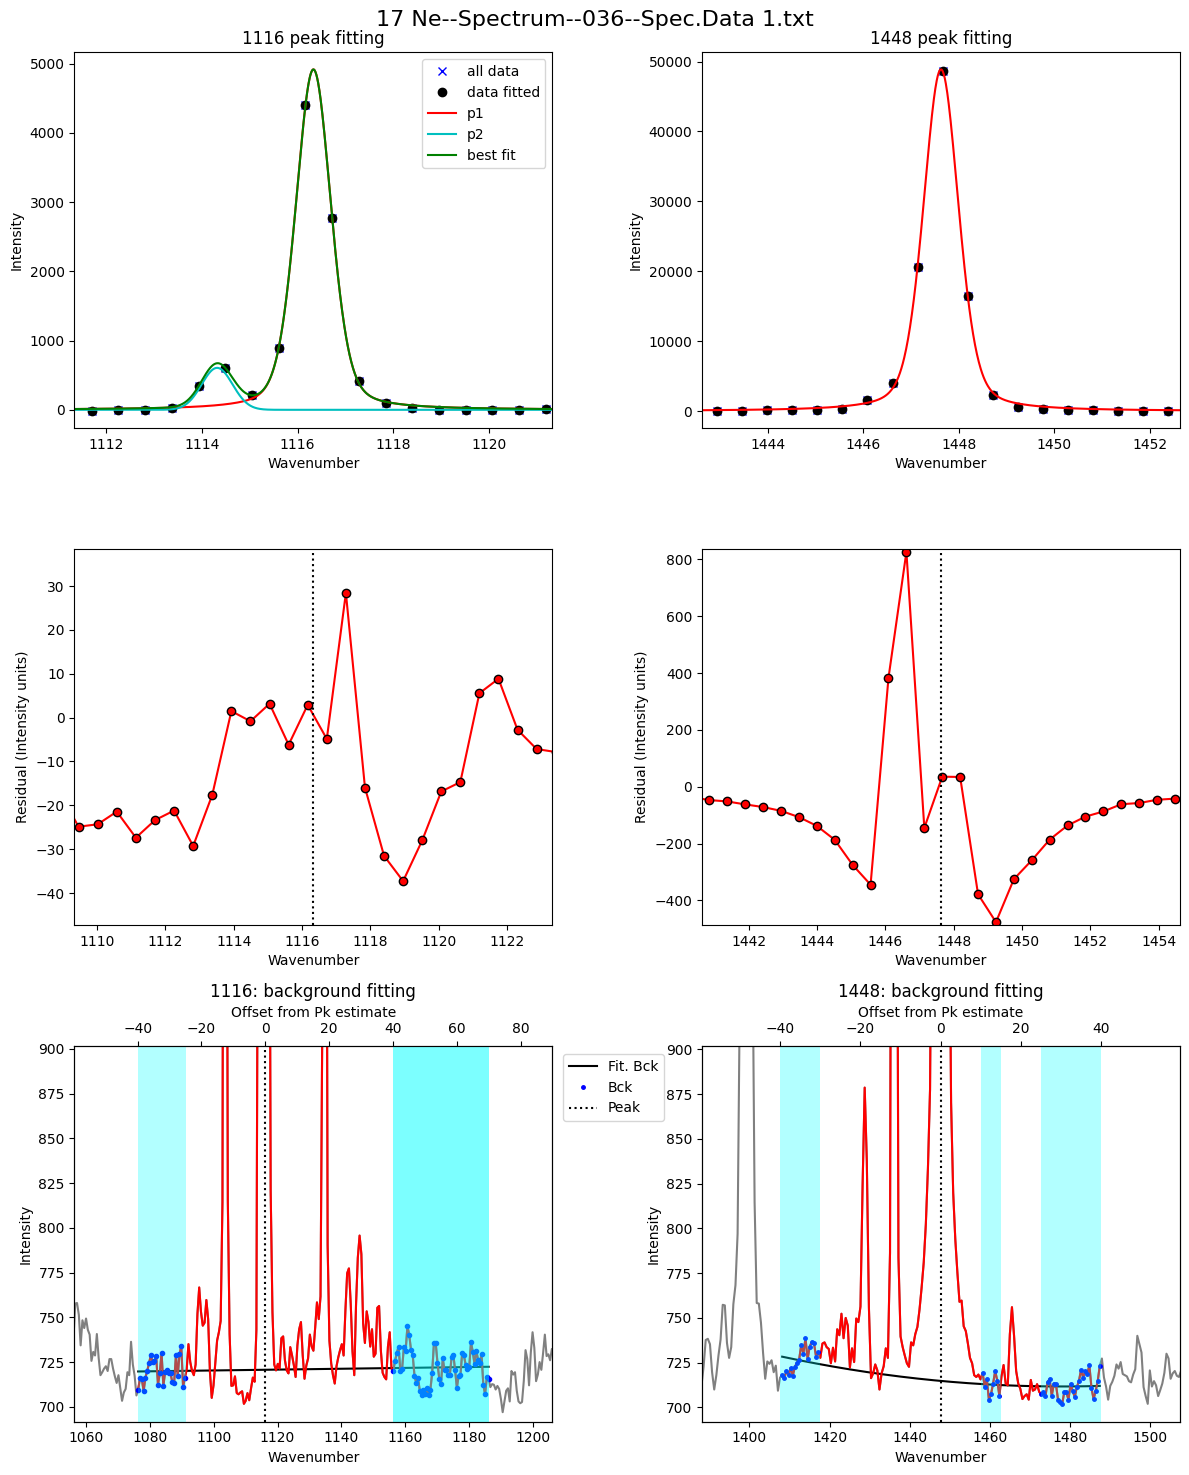

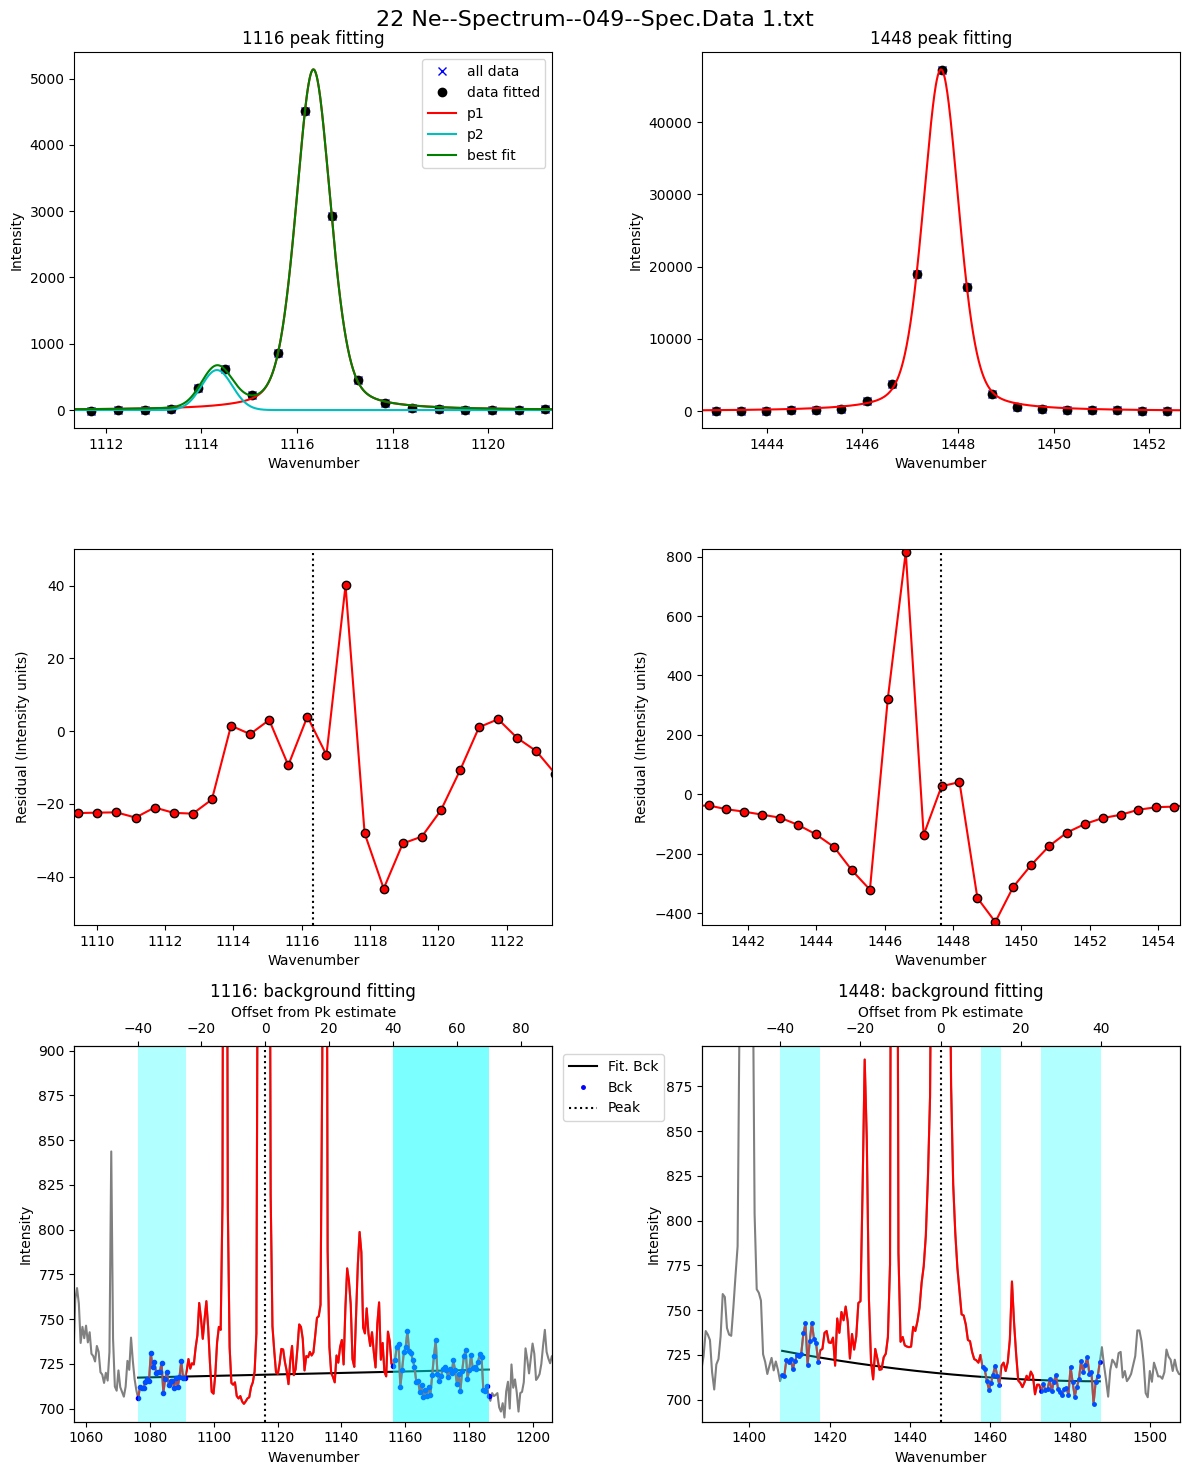

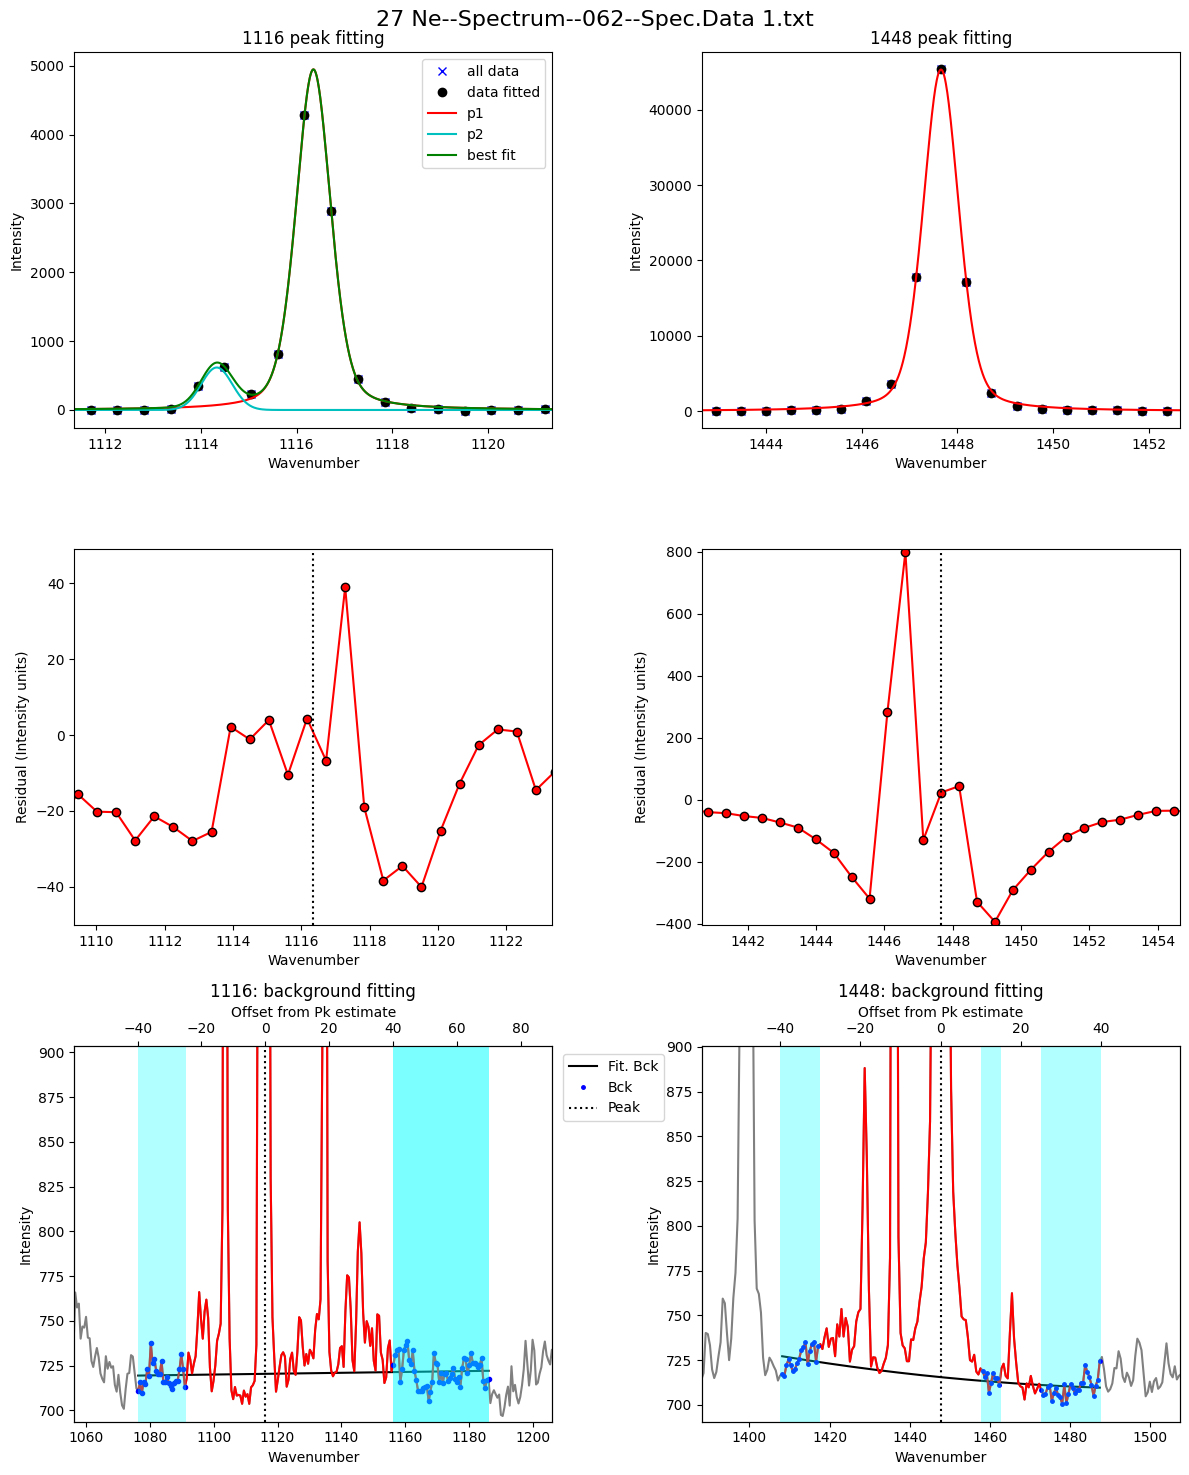

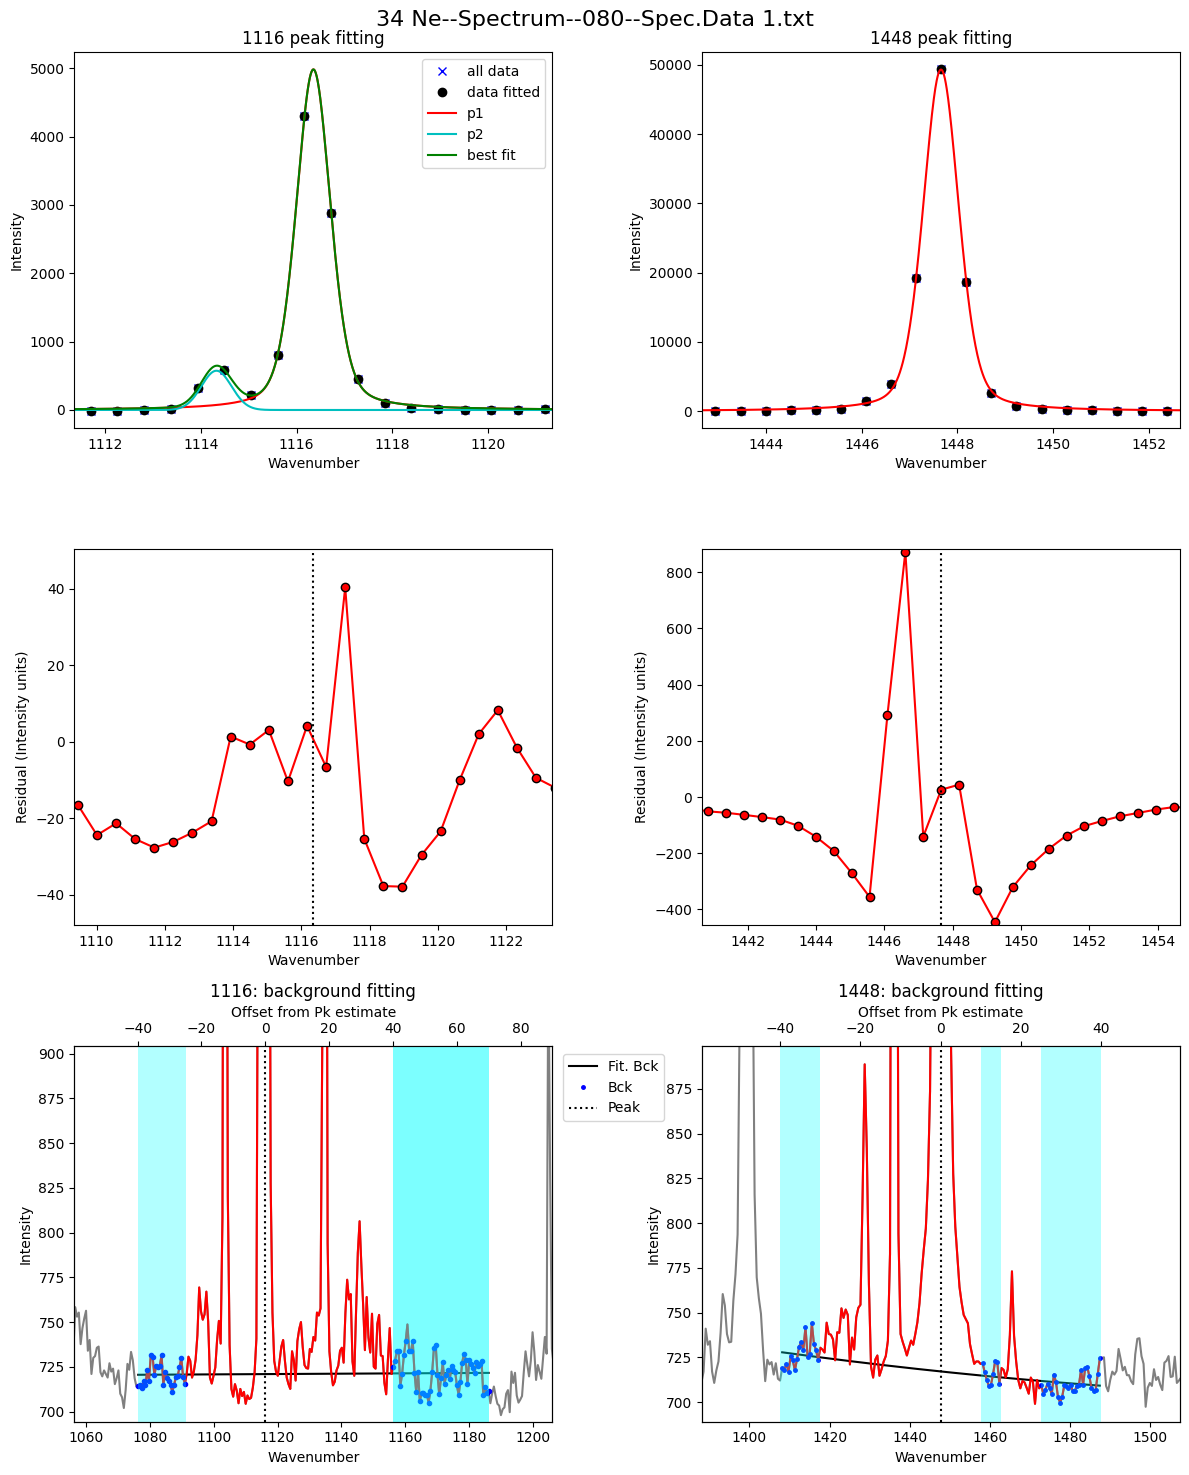

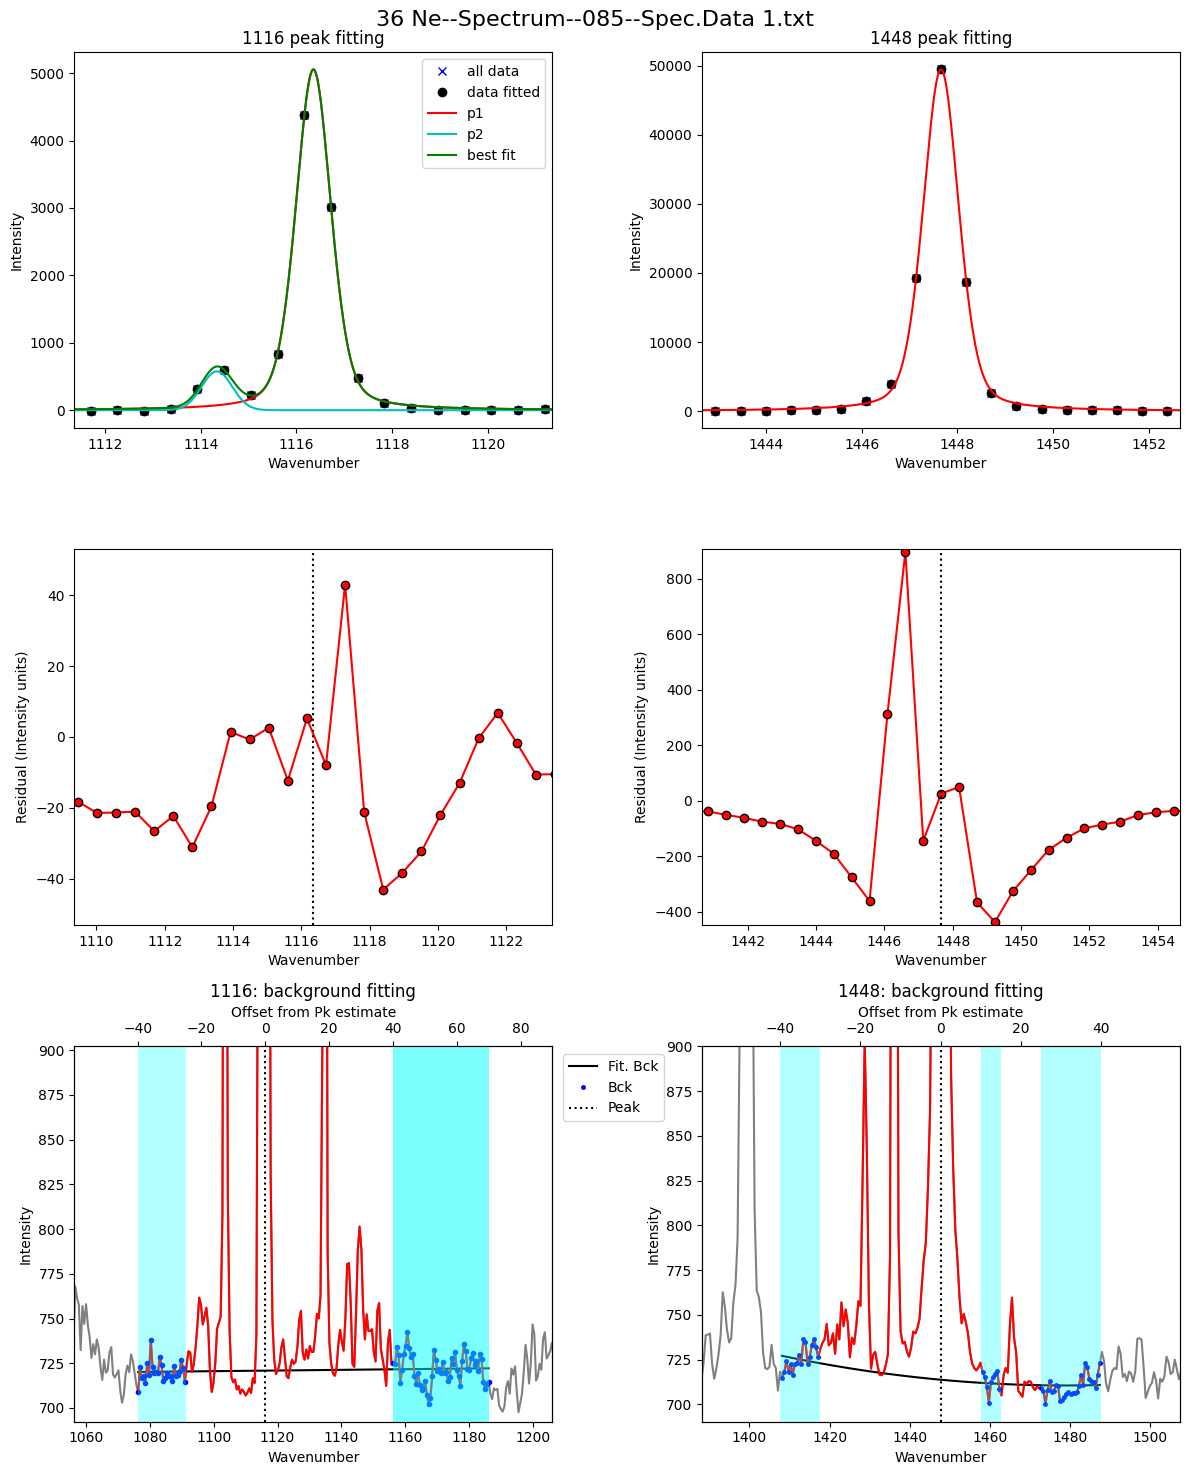

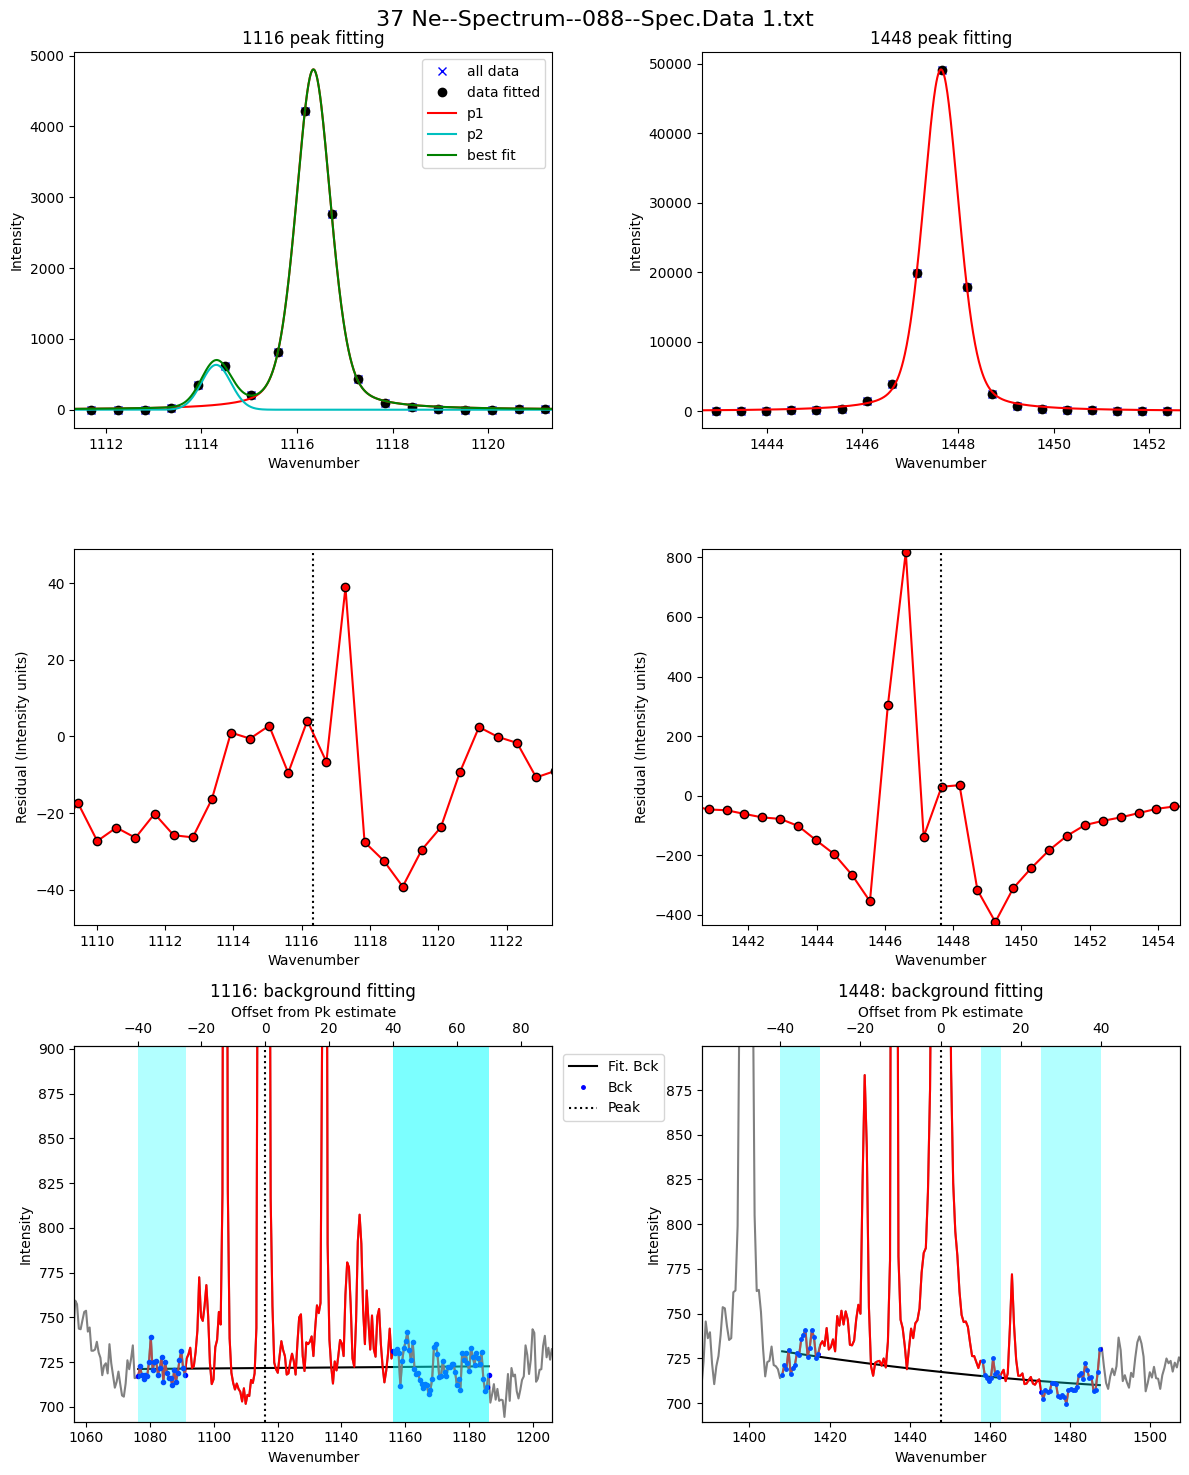

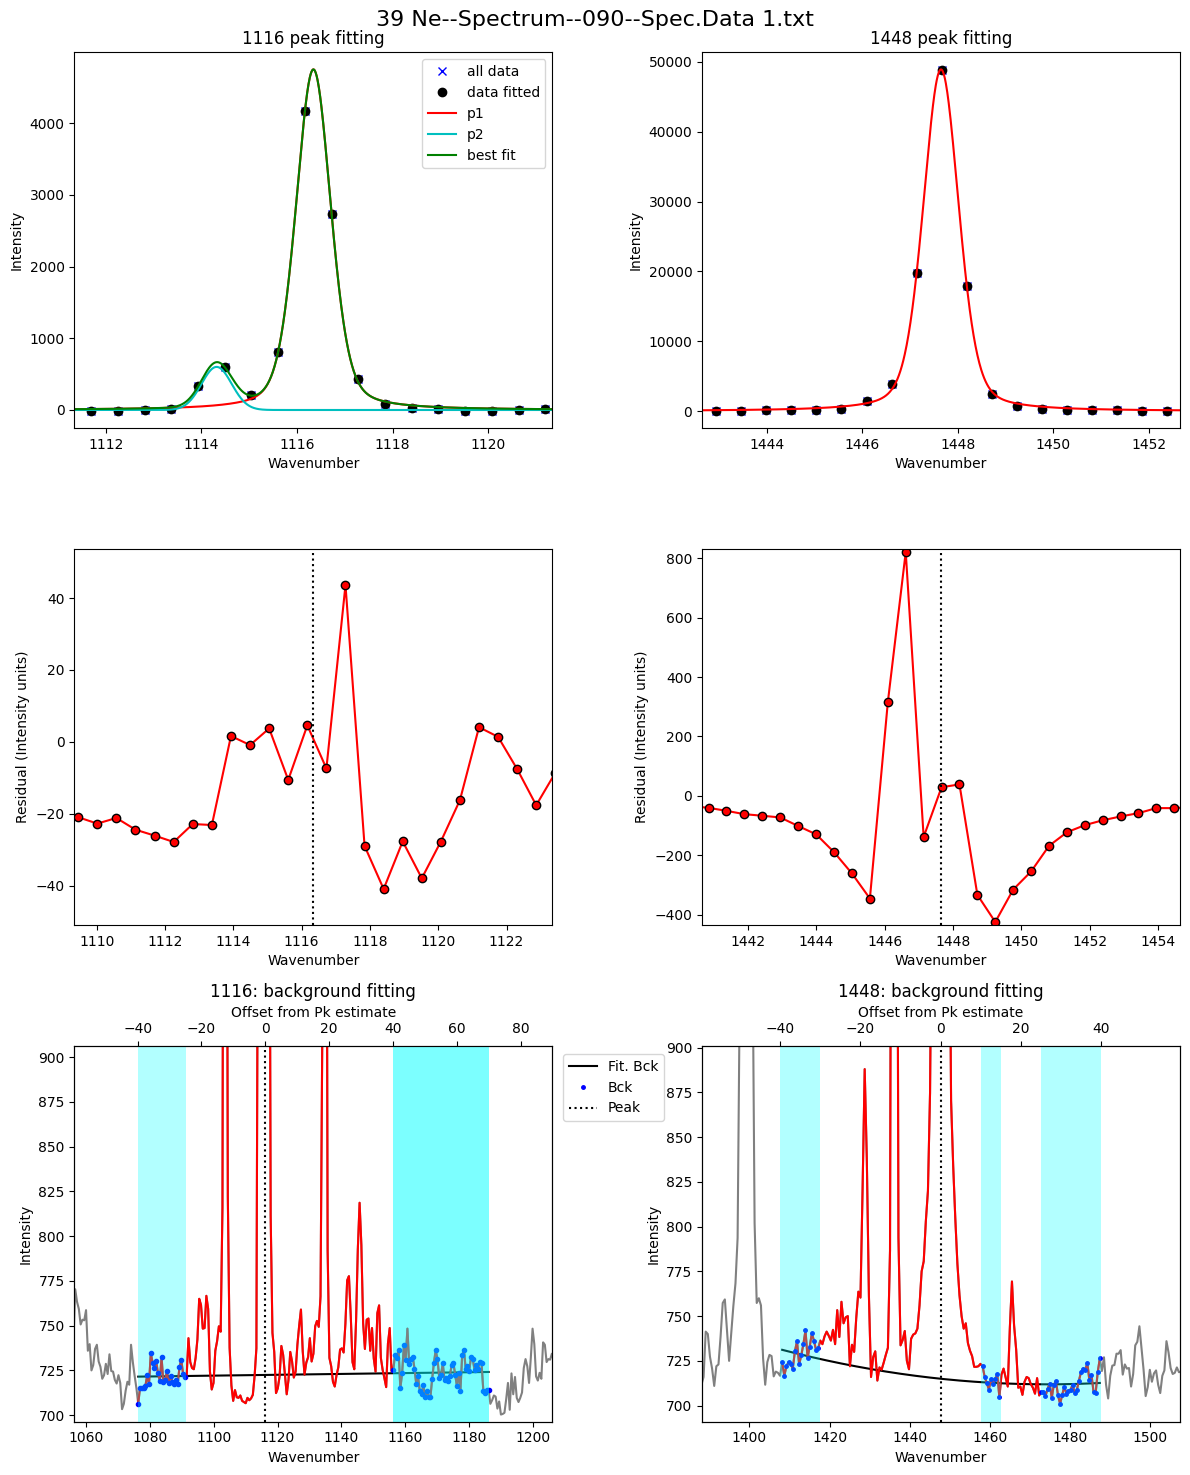

In [13]:
df2=pf.loop_Ne_lines(files=Ne_files, spectra_path=spectra_path, 
filetype=spectra_filetype, config_ID_peaks=Neon_id_config, config=Ne_Config_est,
df_fit_params=df_fit_params,  prefix=prefix,                   
plot_figure=True, const_params=True)


In [14]:
df2

filename   Ne_Corr  1σ_Ne_Corr     deltaNe  \
0   Ne--Spectrum--000--Spec.Data 1.txt  0.997565    0.000037  331.284463   
1   Ne--Spectrum--001--Spec.Data 1.txt  0.997554    0.000038  331.287846   
2   Ne--Spectrum--002--Spec.Data 1.txt  0.997564    0.000037  331.284709   
3   Ne--Spectrum--003--Spec.Data 1.txt  0.997571    0.000037  331.282406   
4   Ne--Spectrum--004--Spec.Data 1.txt  0.997569    0.000037  331.282950   
5   Ne--Spectrum--005--Spec.Data 1.txt  0.997584    0.000037  331.278055   
6   Ne--Spectrum--006--Spec.Data 1.txt  0.997579    0.000039  331.279766   
7   Ne--Spectrum--007--Spec.Data 1.txt  0.997567    0.000037  331.283498   
8   Ne--Spectrum--032--Spec.Data 1.txt  0.997530    0.000037  331.296096   
9   Ne--Spectrum--036--Spec.Data 1.txt  0.997535    0.000037  331.294184   
10  Ne--Spectrum--049--Spec.Data 1.txt  0.997508    0.000036  331.303208   
11  Ne--Spectrum--062--Spec.Data 1.txt  0.997508    0.000037  331.303256   
12  Ne--Spectrum--080--Spec.Data 1.txt  0.997503    0.000038  331.304893   
13  Ne--Spectrum--085--Spec.Data 1.txt  0.997513    0.000036  331.301684   
14  Ne--Spectrum--088--Spec.Data 1.txt  0.997516    0.000039  331.300576   
15  Ne--Spectrum--090--Spec.Data 1.txt  0.997511    0.000039  331.302282   

    pk2_peak_cent  pk1_peak_cent  pk2_amplitude  pk1_amplitude  residual_pk2  \
0     1447.386491    1116.102028   49715.047205    4887.649636     93.674102   
1     1447.401189    1116.113343   47878.391688    4734.761329    110.244633   
2     1447.425126    1116.140416   49993.627660    4755.105872     99.064664   
3     1447.441537    1116.159131   50919.769616    4773.754360    124.879555   
4     1447.460133    1116.177184   51207.793983    4853.296776    127.544379   
5     1447.526377    1116.248322   51875.829727    5068.715317    132.426506   
6     1447.574098    1116.294332   51824.463746    5056.809458    133.793501   
7     1447.581157    1116.297659   51598.053369    5141.171570    133.592815   
8     1447.615987    1116.319891   53356.776905    5308.664294    138.010840   
9     1447.626645    1116.332461   52270.238860    5220.767594    136.470766   
10    1447.646134    1116.342926   50744.376603    5424.019493    126.917174   
11    1447.656490    1116.353234   48804.348539    5242.195463    120.426886   
12    1447.657438    1116.352545   53089.304477    5262.548241    132.662105   
13    1447.657186    1116.355502   53215.500244    5390.160826    134.129678   
14    1447.645172    1116.344596   52837.506093    5111.255787    129.317251   
15    1447.646481    1116.344198   52565.280039    5025.340445    128.194872   

    residual_pk1  ...  Peak2_Prop_Lor  pk1_sigma pk1_gamma  error_pk1  \
0      12.901476  ...        0.228329   0.438396      None   0.012151   
1      13.124476  ...        0.154648   0.440527      None   0.012463   
2      13.999371  ...        0.296927   0.438822      None   0.012244   
3      14.100824  ...        0.395387   0.436473      None   0.012172   
4      12.812352  ...        0.408724   0.435463      None   0.012207   
5      14.202235  ...        0.415603   0.433353      None   0.012008   
6      14.709064  ...        0.419444   0.427673      None   0.012751   
7      16.038817  ...        0.418717   0.428616      None   0.012168   
8      15.054070  ...        0.410793   0.429180      None   0.012015   
9      15.482286  ...        0.416044   0.435494      None   0.012159   
10     15.844256  ...        0.403847   0.428764      None   0.011643   
11     16.661301  ...        0.402848   0.429157      None   0.012119   
12     16.757013  ...        0.403852   0.425201      None   0.012376   
13     16.447408  ...        0.402803   0.433649      None   0.011628   
14     16.209109  ...        0.400216   0.431900      None   0.012953   
15     17.703439  ...        0.399350   0.430873      None   0.012748   

    Peak1_Prop_Lor  Ne_Corr_min Ne_Corr_max  residual_pk1+pk2  \
0         0.299053     0.997523    0.997607        106.575578   
1   

## Now extract metadata to get a timestamp for each file

In [15]:
## Get meta files
Ne_files_meta=pf.get_files(path=meta_path,
file_ext=spectra_file_ext, ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files_meta[0:5]

['01 Ne--Spectrum--000--Information.txt',
 '02 Ne--Spectrum--001--Information.txt',
 '03 Ne--Spectrum--002--Information.txt',
 '04 Ne--Spectrum--003--Information.txt',
 '05 Ne--Spectrum--004--Information.txt']

In [16]:
# This cell stitches metadata together - e.g. gets your laser power, time stamp, accumulations etc
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=Ne_files_meta, prefix=prefix, trupower=TruPower)
meta.head()

100%|██████████| 18/18 [00:00<00:00, 281.92it/s]

Done


filename              date  Month   Day  \
0  Ne--Spectrum--000--Information.txt  March 12, 2024\n  March  12.0   
1  Ne--Spectrum--001--Information.txt  March 12, 2024\n  March  12.0   
2  Ne--Spectrum--002--Information.txt  March 12, 2024\n  March  12.0   
3  Ne--Spectrum--003--Information.txt  March 12, 2024\n  March  12.0   
4  Ne--Spectrum--004--Information.txt  March 12, 2024\n  March  12.0   

   power (mW)  Int_time (s)  accumulations  Mag (X)             duration  \
0       6.043          45.0            3.0      5.0  ['0h', '2m', '17s']   
1       6.099          45.0            3.0      5.0  ['0h', '2m', '16s']   
2       6.103          45.0            3.0      5.0  ['0h', '2m', '18s']   
3       6.043          45.0            3.0      5.0  ['0h', '2m', '16s']   
4       6.009          45.0            3.0      5.0  ['0h', '2m', '16s']   

       24hr_time  sec since midnight  Spectral Center  
0  10:48:17 AM\n             38897.0         1325.004  
1  10:51:36 AM\n             39096.0         1325.004  
2  10:55:47 AM\n             39347.0         1325.004  
3  10:59:48 AM\n             39588.0         1325.004  
4  11:04:50 AM\n             39890.0         1325.004

In [17]:
# This is getting the metadata file names.  Check here the prefix has been removed. 
file_m=pf.extracting_filenames_generic(names=meta['filename'], 
   file_ext=meta_file_ext)
file_m

for i in range(len(file_m)):
    file_m[i] = file_m[i].replace("--Information", "")
file_m


good job, no duplicate file names


array(['Ne--Spectrum--000', 'Ne--Spectrum--001', 'Ne--Spectrum--002',
       'Ne--Spectrum--003', 'Ne--Spectrum--004', 'Ne--Spectrum--005',
       'Ne--Spectrum--006', 'Ne--Spectrum--007', 'Ne--Spectrum--032',
       'Ne--Spectrum--036', 'Ne--Spectrum--049', 'Ne--Spectrum--062',
       'Ne--Spectrum--080', 'Ne--Spectrum--085', 'Ne--Spectrum--088',
       'Ne--Spectrum--090'], dtype=object)

In [18]:
# This is getting the spectra file names. Check that they are in the same format as the metadataones above, this is what you need to successfully stitch together. 
file_s=pf.extracting_filenames_generic(names=df2['filename'],
   file_ext=spectra_file_ext)
file_s

for i in range(len(file_s)):
    file_s[i] = file_s[i].replace("--Spec.Data 1", "")
file_s

good job, no duplicate file names


array(['Ne--Spectrum--000', 'Ne--Spectrum--001', 'Ne--Spectrum--002',
       'Ne--Spectrum--003', 'Ne--Spectrum--004', 'Ne--Spectrum--005',
       'Ne--Spectrum--006', 'Ne--Spectrum--007', 'Ne--Spectrum--032',
       'Ne--Spectrum--036', 'Ne--Spectrum--049', 'Ne--Spectrum--062',
       'Ne--Spectrum--080', 'Ne--Spectrum--085', 'Ne--Spectrum--088',
       'Ne--Spectrum--090'], dtype=object)

## Combine 2 dataframes
- Here we add a new column to each dataframe with these stripped back names, and then merge the 2 dataframes

In [19]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')
print('Number merged= '+str(len(df_combo))+', Check this is what you expected, else check file_m and file_s look the same')

Number merged= 16, Check this is what you expected, else check file_m and file_s look the same


## Now lets inspect changes in Ne correction factor with time
- Normally, you can spot outliers this way

In [20]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo_sort.to_excel('PseudoVoigt.xlsx')

In [21]:
0.4/df_combo['error_pk2']

0     223.655652
1     197.221362
2     239.456914
3     241.143850
4     225.700330
5     208.469989
6     206.218224
7     204.509350
8     211.107289
9     207.702056
10    207.025527
11    202.641554
12    208.033086
13    205.610047
14    217.096392
15    216.373001
Name: error_pk2, dtype: float64

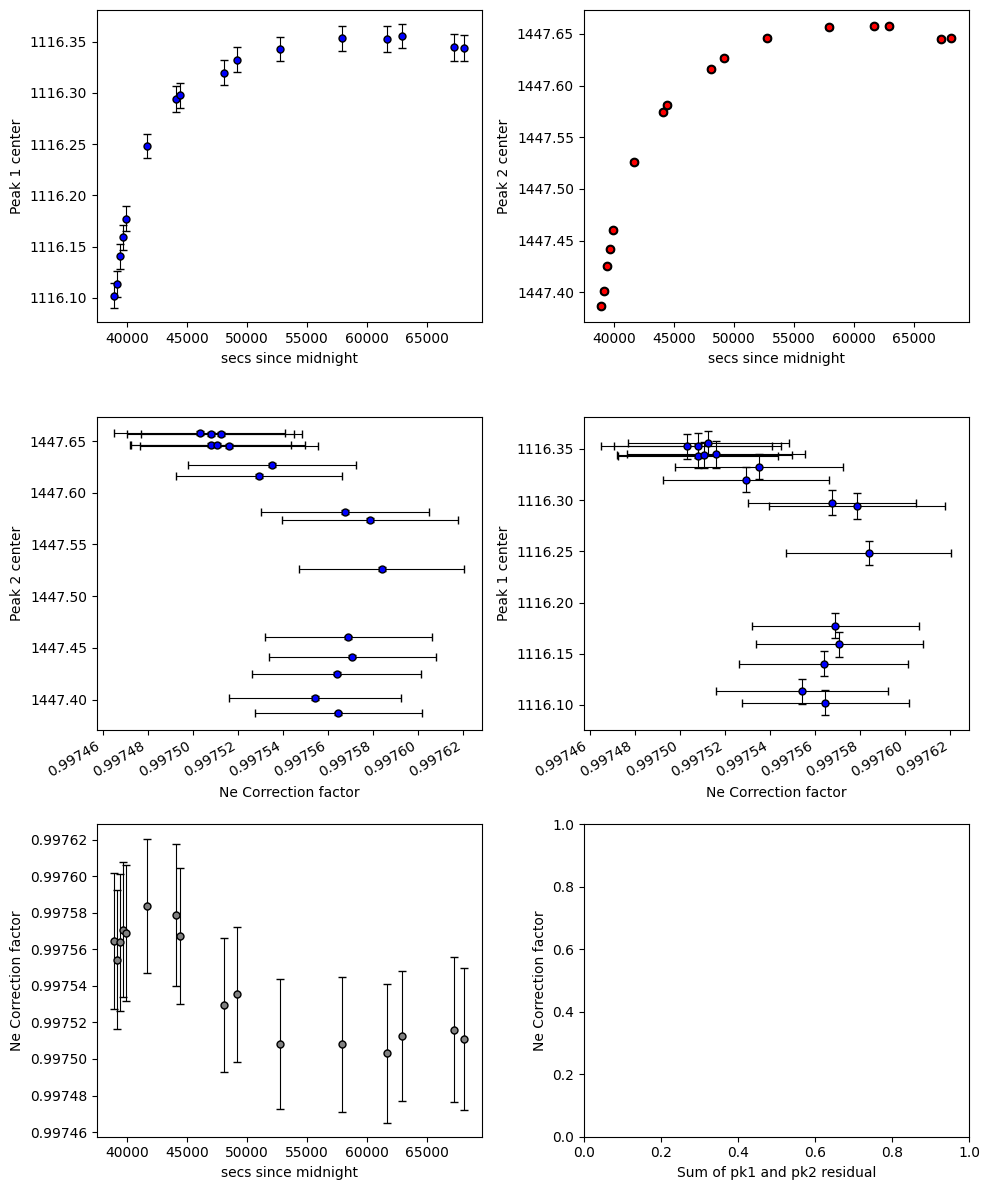

In [22]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')


In [23]:
103.2*0.9979

102.98328000000001

## Exclude ones that don't look right...
- The filter_Ne_Line_neighbours excludes Ne lines that have a correction factor more than "offset" from their N neighbours (defined by "number_av")
- Tweak offset and number_av until you exclude the ones that dont look right
- Smaller number of offset - more discarded
- If you notice really bad fits, you can also exclude certain files like file_name_filt=['Ne_line_1.txt'], or file_name_filt=['Ne_line_2.txt', 'Ne_line_5.txt']

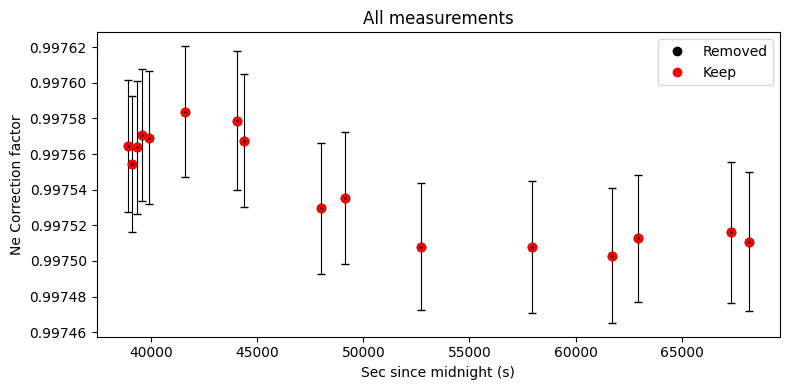

In [24]:
filt=pf.filter_Ne_Line_neighbours(df_combo=df_combo, 
                    number_av=3, offset=0.001, file_name_filt=None)
# Now lets plot this to see
fig, (ax1) = plt.subplots(1, 1, figsize=(8,4))
ax1.errorbar(df_combo['sec since midnight'], df_combo['Ne_Corr'], xerr=0, 
yerr=df_combo['1σ_Ne_Corr'], fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=1, mec='k', capsize=3)
ax1.plot(df_combo['sec since midnight'], df_combo['Ne_Corr'],   'ok', label='Removed')
ax1.plot(df_combo['sec since midnight'], filt,  'or', label='Keep')

ax1.legend()

ax1.set_xlabel('Sec since midnight (s)')
ax1.set_ylabel('Ne Correction factor')
ax1.set_title('All measurements')

fig.tight_layout()

## Now lets make a regression against time
- We take this time regression and then apply to our diad fits

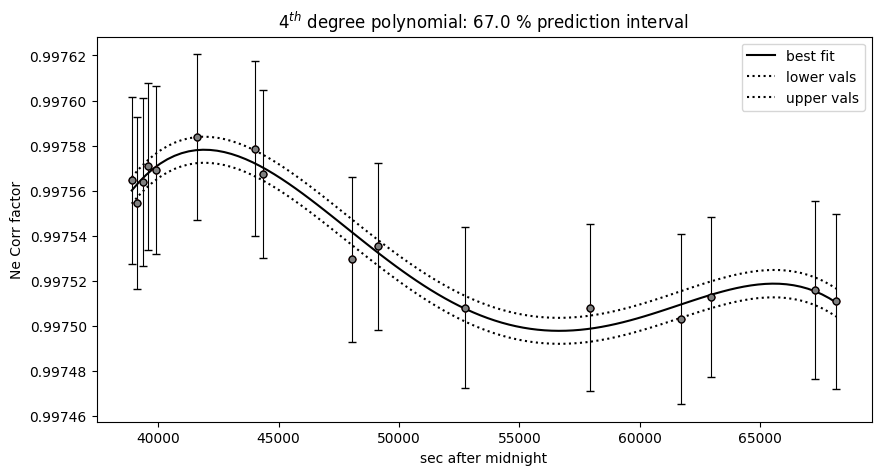

In [30]:

big_err=df_combo['1σ_Ne_Corr']>0.0001
## Lets get filtered ones
keep=(filt>0)&(~big_err)

pf.generate_Ne_corr_model(time=df_combo['sec since midnight'].loc[keep], Ne_corr=df_combo.loc[keep], 
N_poly=4, CI=0.67, pkl_name='Neon_corr_model.pkl')


In [31]:
import os

if os.name=="posix":

    def mac_notification(title, subtitle, message):
        """
        Display a macOS notification with the default sound using AppleScript.
        
        Args:
        - title: Title of the notification.
        - subtitle: Subtitle of the notification.
        - message: Main message content of the notification.
        """
        os.system("""
                osascript -e 'display notification "{}" with title "{}" subtitle "{}" sound name "default"'
                """.format(message, title, subtitle))

    mac_notification("Notebook Completed", "VSCode", "Step1 Ne lines")

else:

    # %pip install winotify

    from winotify import Notification, audio

    toast= Notification(app_id="VSCode",title="Notebook completed",
                        msg="Step1 Ne lines is done!",
                        duration="short")
    toast.set_audio(audio.Mail,loop=False)
    toast.show()